<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios d'Informàtica, Multimèdia y Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRACTICA: Implementació d'un agent per a la robòtica espacial


## 1. Presentació

Al llarg de les tres parts de l'assignatura hem entrat en contacte amb diferents classes d'algoritmes d'aprenentatge per reforç que permeten resoldre problemes de control en una gran varietat d'entorns.

Aquesta pràctica, que s'estendrà al llarg d'un mes aproximadament, dóna la possibilitat d'enfrontar-se al disseny d'un agent per solucionar un cas específic de robotica.

Atacarem el problema a partir de l'exploració de l'entorn i les observacions. Després passarem a la selecció de l'algorisme més oportú per solucionar l'entorn en qüestió amb les observacions seleccionades. Finalment, passarem per l'entrenament i la prova de l'agent fins a arribar a l'anàlisi del rendiment.

Per fer-ho, es presentarà abans l'entorn de referència. Posteriorment, es passarà a la implementació d'un agent Deep Q-Network (DQN) que el solucioni. Després d'aquestes dues primeres fases de presa de contacte amb el problema, es cercarà un altre agent que pugui millorar el rendiment de l'agent DQN implementat anteriorment.

## 2. Competències
En aquesta activitat es treballen les següents competències:

● Capacitat per analitzar un problema des del punt de vista de l'aprenentatge per reforç.

● Capacitat per analitzar un problema en el nivell d'abstracció adequat a cada situació i aplicar les habilitats i coneixements adquirits per resoldre'ls.


## 3. Objectius
Els objectius concrets d'aquesta activitat són:

● Conèixer i aprofundir en el desenvolupament d'un entorn real que es pugui resoldre mitjançant tècniques d'aprenentatge per reforç.

● Aprendre a aplicar i comparar diferents mètodes d'aprenentatge per reforç per poder seleccionar el més adequat a un entorn i problemàtica concreta.

● Saber implementar els diferents mètodes, basats en solucions tabulars i solucions aproximades, per a resoldre un problema concret.

● Extreure conclusions a partir dels resultats obtinguts.

## 4. Entorn

Estem treballant sobre el problema de guia autònoma i en particular volem solucionar el cas de l’aterratge propi, per exemple, dels drons autònoms.

Per això, s'escull lunar-lander com a entorn simplificat. L'entorn es pot trobar al següent enllaç:
https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

Lunar Lander consisteix en una nau espacial que ha d'aterrar a un lloc determinat del camp d'observació. L'agent condueix la nau i el seu objectiu és aconseguir aterrar a la pista d'aterratge, coordenades (0,0), i arribar amb velocitat 0.

La nau consta de tres motors (esquerra, dreta i el principal que té a sota) que li permeten anar corregint el rumb fins a arribar a la destinació.

Les accions que pot fer la nau (espai d'accions) són discretes.

Les recompenses obtingudes al llarg del procés d'aterratge depenen de les accions que es prenen i del resultat que se'n deriva.

    ● Desplaçar-vos de dalt a baix, fins a la zona d'aterratge pot resultar en [+100,+140] punts

    ● Si s'estrella a terra, perd 100 punts (recompensa -100 punts)

    ● Si aconsegueix aterrar a la zona d'aterratge (velocitat 0), guanya +100 punts

    ● Si aterra, però no a la zona d'aterratge (fora de les banderes grogues) es perden punts

    ● El contacte d'una pota amb el terra rep +10 punts (si es perd contacte després d'aterrar, es perden punts)

    ● Cada cop que encén el motor principal perd 0.3 punts (recompensa -0.3 punts)

    ● Cada cop que encén un dels motors d'esquerra o dreta, perd 0,03 punts (recompensa -0.3 punts)

La solució òptima és aquella en què l'agent, amb un desplaçament eficient, aconsegueix aterrar a la zona d'aterratge (0,0), tocant amb les dues potes a terra i amb velocitat nul·la. Es considera que l'agent ha après a fer la tasca (i.e. el “joc” acaba) quan obté una mitjana d'almenys 200 punts durant 100 episodis consecutius.

In [1]:
import warnings
import time
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
!pip install gym[atari]==0.25.0
!pip install autorom[accept-rom-license]
!pip install gym[box2d]
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
from copy import deepcopy
from datetime import datetime

In [2]:
# Comprovació de la versió de GYM instal·lada
print('La versió de gym instal·lada: ' + gym.__version__)

# Comprovació d'entorn amb gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("L'entorn utilitza: ", device)

La versió de gym instal·lada: 0.25.0
L'entorn utilitza:  cpu


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.1 (0.5 punts)</strong> Es demana explorar l’entorn i representar una execució aleatòria.
</div>


In [3]:
warnings.filterwarnings('ignore')
env = gym.make('LunarLander-v2')

print("- Rang de recompenses o llindar de les recompenses: {} ".format(env.reward_range))
print("- Màxim nombre de passos per episodi: {} ".format(env.spec.max_episode_steps)) 
print("- Espai d'accions: {} ".format(env.action_space.n))
print("- Espai d'estats continuu: {} ".format(env.continuous))
print("- Espai d'observacions: {} ".format(env.observation_space))


- Rang de recompenses o llindar de les recompenses: (-inf, inf) 
- Màxim nombre de passos per episodi: 1000 
- Espai d'accions: 4 
- Espai d'estats continuu: False 
- Espai d'observacions: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32) 


Hem pogut veure que el llindar de recompenses pot anar des de -infinit fins a +infinit. També que per cada episodi tenim un màxim de 1000 passos. Les accions són 4 que les comentarem en el següent exercici i aquestes són discretas (es pot configurar per a que siguin continues). L'espai d'observacions l'hem visualitzat i també el comentarem més endavant. Ara farem una execució aleatoria.

In [4]:
# inicialitzem l'entorn
obs = env.reset()
t, total_reward, done = 0, 0, False

# mostrem informació inicial
print("Obs: {}".format(obs))

while not done:
    
    # escollim la acció aleatoria
    action = env.action_space.sample()
    
    # executem la acció i obtenim el nou estat, la recompensa i si hem acabat    
    new_obs, reward, done, info = env.step(action)
    
    # mostrem informació
    print("\nObs: {} \nAcció: {} \nRecompensa: {} \nDone: {}".format(new_obs, action, reward, done))

    # Actualizar variables
    obs = new_obs
    total_reward += reward
    t += 1
    
print("Episodi finalitzat després de {} passos i recompensa de {} ".format(t, total_reward))
env.close()

Obs: [ 0.00794897  1.4092269   0.80513066 -0.07527833 -0.0092041  -0.18237418
  0.          0.        ]

Obs: [ 0.01589823  1.4069574   0.80404174 -0.10095128 -0.01821596 -0.18025352
  0.          0.        ] 
Acció: 0 
Recompensa: -0.8521986916342996 
Done: False

Obs: [ 0.02384796  1.4040891   0.8040697  -0.12762192 -0.02722242 -0.18014577
  0.          0.        ] 
Acció: 0 
Recompensa: -1.003116719167224 
Done: False

Obs: [ 0.03172417  1.4006214   0.79485804 -0.15426902 -0.0343754  -0.14307266
  0.          0.        ] 
Acció: 1 
Recompensa: 0.03025874117179342 
Done: False

Obs: [ 0.03951464  1.3965662   0.7840777  -0.18036069 -0.03935574 -0.09961586
  0.          0.        ] 
Acció: 1 
Recompensa: 0.3710988073751207 
Done: False

Obs: [ 0.0473053   1.3919111   0.7840912  -0.20703109 -0.04433582 -0.09961095
  0.          0.        ] 
Acció: 0 
Recompensa: -0.6978284963086878 
Done: False

Obs: [ 0.05509605  1.3866564   0.7841055  -0.2337014  -0.04931465 -0.09958588
  0.          

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.2 (0.5 punts)</strong>
Explicar els espais d'observacions i d'accions possibles (informe escrit).    
</div>

- Espai d'accions: com hem vist en l'exercici anterior l'espai d'accions és de 4. Hem definit un espai discret (podria ser continu). Les accions són les següents: 
    - Nop (no fer res)
    - Fire left engine (motor esquerra)
    - Main engine (motor principal)
    - Right engine (motor dret)
    

- Espai d'observacions: l'espai d'observacions està formada per un vector amb 8 coordenades.
    - la coordenada de x
    - la coordenada de y
    - la velocitat linear de x
    - la velocitat linear de y
    - l'angle
    - la velocitat angular
    - dos boolean que diuen si cada una de les potes està en contacte amb el terra

Anem a executar 1000 prenent accions de forma aleatòria. Emmagatzerem tant la suma de recompenses de cada partida com la quantitat d'episodis executats.

In [5]:
def play_games(num_games):    
    steps_list = []
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        total_reward, steps, done = 0, 0, False
        env.reset()
        while not done:         
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1
            if done:    
                steps_list.append(steps)
                total_reward_list.append(total_reward)
    return steps_list, total_reward_list      
          
steps_list, total_reward_list = play_games(1000)
env.close()   

Episode 999/1000.

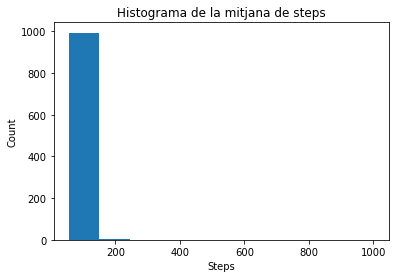

In [6]:
plt.hist(steps_list)
plt.title('Histograma de la mitjana de steps')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.show()

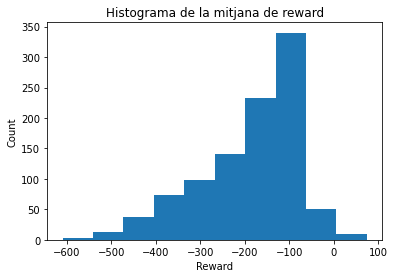

In [7]:
plt.hist(total_reward_list)
plt.title('Histograma de la mitjana de reward')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

In [8]:
print("La mitjana de les passes per episodi és de: {} ".format(np.mean(steps_list)))
print("La mitjana de les recompenses per episodi és de: {} ".format(np.mean(total_reward_list)))

La mitjana de les passes per episodi és de: 91.957 
La mitjana de les recompenses per episodi és de: -187.54748757292558 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
La mitjana de passes és del voltant de mes de 90 i la recomenpensa mitjana dels episodis és força negatiu. Fent servir algoritmes Deep Q-Networks hauriem d'aconseguir millorar aquests valors de recompensa ja que hem triat accions totalment aleatories. 
</div>

## 5. Agent de referència

A la tercera part de l'assignatura hem introduït l'agent DQN amb replay buffer i target network, que és un bon candidat per a la solució del problema de robòtica que estem analitzant, donat que permet controlar entorns amb un nombre elevat d'estats i accions de forma eficient.

Es demana resoldre els 3 exercicis següents.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.1 (1.5 punts):</strong> Implementar un agent DQN per a l'entorn lunar-lander.
</div>

Per entrenar una xarxa neuronal per resoldre el problema de "LunarLander-v2" fem servir una arquitectura amb una capa d'entrada amb 8 canals d'entrada (per cada un dels atributs de les observacions), una capa intermitja amb 64 entrades i 64 sortides i finalment una capa de sortida amb les 64 entrades i 4 sortides (una per cada una de les possibles accions).

In [9]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

class DQNetwork(nn.Module):
    """ Deep Q-Network model  per a l'entrenament de l'agent DQN """
 
    def __init__(self, n_state, n_action, seed, n_layer1=64, n_layer2=64):
        """
        Inicialització de la xarxa neuronal
        Params
        =======
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            n_layer1 (int): Nombre de nodes en la primera capa oculta
            n_layer2 (int): Nombre de nodes en la segona capa oculta
            seed (int): Random seed per a inicialitzar els valors aleatoris
        """
        super(DQNetwork, self).__init__()
        self.seed = T.manual_seed(seed)
        self.fc1 = nn.Linear(n_state, n_layer1)
        self.fc2 = nn.Linear(n_layer1, n_layer2)
        self.fc3 = nn.Linear(n_layer2, n_action)

    def forward(self, state):
        """
        Forward pass de la xarxa neuronal amb una capa oculta de 64 nodes i una capa de sortida de 4 nodes (una per cada acció)
        amb activació ReLU en les dues capes ocultes i activació lineal en la capa de sortida 
        """
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        return self.fc3(state)

Fem servir tant l'algorisme d'optimització Ada. A més també tenim l'algoritme e-greedy per a que anem alternant accions aleatories amb accions de l'aprenentatge. Al principi totes són aleatories i posteriorment de forma incremental anem afegint del model.

Tal i com demana l'enunciat fem servir un buffer per evitar la repetició de accions seqüencials i evitar la correlació entre ellas. Alhora implementem una xarxa objectiu i una principal que evita que es vicii en excés l'aprenentatge, estabilitzar-lo i que no ens centrem només en uns certs espai d'accions.

Encara que no está al enunciat de la pràctica per a realitzar la còpia de de la xarxa local a la target fem servir un soft update. En comptes de realitzar la còpia cada certes passes el que fem és atenuar aquests valors copiats a partir d'un valor de Tau com a hiperparàmetre.

In [10]:
class Agent:
    """ Agent que interactua amb l'entorn i apren a través de DQN"""    
    def __init__(self, env, seed, learning_rate=1e-3, gamma=0.99, tau=1e-3, buffer_size=100000, batch_size=64, dnn_upd=4):
        """ Inicialitza l'agent per a l'aprenentatge per DQN
            L'agent inicialitza la xarxa neuronal local i target, el buffer de memòria i l'optimitzador    
        Params
        ======
            env: Entorn de gym
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            seed (int): Random seed per a inicialitzar els valors aleatoris
            learning_rate (float): Velocitat d'aprenentatge
            gamma (float): Valor gamma de l'equació de Bellman
            tau (float): Valor de tau per a soft update del target network
            buffer_size (int): Màxima capacitat del buffer
            batch_size (int): Conjunt a agafar del buffer per a la xarxa neuronal     
            dnn_upd (int): Freqüència d'actualització de la xarxa neuronal       
        """
        self.env = env
        self.seed = seed         
        self.n_state = env.observation_space.shape[0] 
        self.n_action = env.action_space.n
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.buffer_size = buffer_size
        self.batch_size = batch_size        
        self.dnn_upd = dnn_upd
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu") # Si hi ha GPU, utilitza-la

         
        random.seed(seed)   

        if T.cuda.is_available():
            print(f'Running on {T.cuda.get_device_name(0)}')            
        else:
            print('Running on CPU')
               
        # Inicialització de les xarxes locals i target i de l'optimitzador
        self.__initialize_networks()

    def __initialize_networks(self):
        # Inicialització de les xarxes locals i target            
        self.qnetwork_local = DQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        self.qnetwork_target = DQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        # Inicialització de l'optimitzador
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.learning_rate)

        # Inicialització del buffer de memòria
        self.memory = ReplayBuffer(self.n_action, self.buffer_size, self.batch_size, self.seed)
        
        # Inicialització del comptador de pasos per a l'actualització de la xarxa neuronal
        self.t_step = 0

    def __take_step(self, state, action, reward, next_state, done):
        """
        Afegeix l'experiència a la memòria i actualitza la xarxa neuronal
        """
        # emmagatzemar l'experiència en el buffer de memòria
        self.memory.append(state, action, reward, next_state, done)

        # Actualitzar la xarxa neuronal cada dnn_upd pasos
        self.t_step = (self.t_step + 1) % self.dnn_upd
        if self.t_step == 0:
            # Si hi ha suficients experiències en el buffer, agafar un lot i actualitzar la xarxa neuronal
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample_batch()
                self.__update(experiences, self.gamma)

    def get_action(self, state, eps):
        """
        Retorna l'acció segons l'estat actual i l'epsilon-greedy
        """
        state = T.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with T.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy per a seleccionar l'acció. 
        # Si el valor aleatori és més gran que l'epsilon agafar l'acció amb el valor més alt segons la xarxa neuronal
        # Si no, agafar una acció aleatòria
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_action))

    def __update(self, experiences, gamma):
        """
        Actualitza els pesos de la xarxa neuronal local i target
        """
        states, actions, rewards, next_states, dones = experiences

        # obtenir els valors Q de l'estat següent segons la xarxa neuronal target
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # calcular els valors Q segons l'equació de Bellman teni en compte si l'estat és terminal i el parametre gamma
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        # obtenir els valors Q de l'estat actual segons la xarxa neuronal local
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # calcular la funció de pèrdua segons l'error quadràtic mitjà
        loss = F.mse_loss(q_expected, q_targets)

        # minimitzar la funció de pèrdua amb l'optimitzador
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

        # actualitzar els pesos de la xarxa neuronal target amb un soft update per a reduir el problema de l'estabilitat
        self.__soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def __soft_update(self, local_model, target_model, tau):
        """
        Soft update dels pesos de la xarxa neuronal target
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)    


    def train(self, n_episodes=2000, max_t=1000, eps_start=1.0, eps_min=0.01, eps_decay=0.995, nblock =100, min_episodes=250, reward_threshold=200.0):
        """Deep Q-Learning.

        Params
        ======
            n_episodes (int): nombre màxim d'episodis
            max_t (int): maxim nombre de pasos per episodi
            eps_start (float): valor inicial d'epsilon
            eps_min (float): valor mínim d'epsilon
            eps_decay (float): factor de decaig d'epsilon
        """
        self.eps_decay = eps_decay
        self.reward_threshold = reward_threshold
        self.eps = eps_start  # inicialitzar epsilon
        self.nblock = nblock
        self.total_episodes = 0
        
        self.update_loss = [] 
        self.mean_update_loss = [] # llista amb els valors de la funció de pèrdua per episodi
        
        self.sync_eps = [] 

        self.training_rewards = []  # llista amb els reward per episodi
        self.mean_training_rewards = []  # llista amb la mitjana dels reward per episodi

        start_time = datetime.now()
        print("Training...")
        
        for episode in range(1, n_episodes + 1):
            state = self.env.reset()
            self.total_reward = 0   
            self.total_time = 0
            
            for t in range(max_t):
                action = self.get_action(state, self.eps)
                next_state, reward, done, _ = self.env.step(action)
                self.__take_step(state, action, reward, next_state, done)
                state = next_state
                self.total_reward += reward
                if done:
                    break

            # actualitzar epsilon
            self.eps = max(eps_min, self.eps_decay * self.eps)  # decrease epsilon            
            
            # afegir el reward de l'episodi a la llista
            self.__save_statistics()
            
            # mostrar informació de l'episodi actual
            self.__log_info(start_time, episode)
            
            ### comprovar si s'ha assolit el màxim d'episodis
            training = not self.__is_solved_by_episode(episode, n_episodes) and not self.__is_solved_by_reward(episode, min_episodes, self.__get_mean_training_rewards())
                        
            ### si no s'ha assolit el màxim d'episodis, continuar entrenant
            if not training:
                print('\nTraining finished.')
                self.total_time = datetime.now() - start_time
                self.total_episodes = episode
                break

            if episode % 100 == 0:
                print('\rEpisode {}\tMean Rewards: {:.2f}\t'.format(episode, self.__get_mean_training_rewards()))
  

    def __get_mean_training_rewards(self):
        return np.mean(self.training_rewards[-self.nblock:])

    ######## Emmagatzemar epsilon, training rewards i loss#######
    def __save_statistics(self):
        self.sync_eps.append(self.eps)              
        self.training_rewards.append(self.total_reward)         
        self.mean_training_rewards.append(np.mean(self.training_rewards[-self.nblock:]))
        self.mean_update_loss.append(np.mean(self.update_loss))                                         
        self.update_loss = []
   
    ######## Comprovar si s'ha arribat al llindar de recompensa i un mínim d'episodis
    def __is_solved_by_reward(self, episode, min_episodios, mean_rewards):  
        if mean_rewards >= self.reward_threshold and min_episodios <  episode:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, mean_rewards))
            T.save(self.qnetwork_local.state_dict(), 'data.pth')
            return True
        else:
            return False

    ######## Comprovar si s'ha arribat al màxim d'episodis
    def __is_solved_by_episode(self, episode, max_episodes):
        if episode >= max_episodes:
            print('\nEpisode limit reached.')
            return True
        else:
            return False        


    ######## Mostrar informació de l'episodi actual
    def __log_info(self, start_time, episode):
        end_time = datetime.now()
        # get difference time
        delta = end_time - start_time 
        # time difference in minutes
        total_minutes = delta.total_seconds() / 60           
        print('\rEpisode {}\tMean Rewards: {:.2f}\tEpsilon {}\tTime {} minutes\t'
              .format(episode, self.__get_mean_training_rewards(), round(self.eps,4), round(total_minutes,2)), end="")                    

In [11]:
from collections import deque, namedtuple
import random
import numpy as np

import torch as T

class ReplayBuffer:
            
    """ Definim la classe ReplayBuffer que ens permetrà guardar les experiències de l'agent i poder-les reutilitzar posteriorment. """

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """ Inicialitzem els paràmetres de la classe ReplayBuffer.
        Params
        ======
            action_size (int): dimension de l'espai d'accions
            buffer_size (int): mida del buffer
            batch_size (int): tamany de la mostra del batch
            seed (int): seed per inicialitzar el generador de nombres aleatoris
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

    def append(self, state, action, reward, next_state, done):
        """ Afegeix una experiència al buffer de memòria. """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample_batch(self):
        """ Retorna una mostra aleatòria de tamany batch_size experiències del buffer de memòria.  """
        experiences = random.sample(self.memory, k=self.batch_size)

        states = T.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = T.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = T.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = T.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = T.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """ Retorna el tamany actual del buffer de memòria. """
        return len(self.memory)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.2 (1 punt):</strong> Entreneu l'agent DQN i busqueu els valors dels hiperparàmetres que obtinguin un alt rendiment de l'agent. Per fer-ho, cal llistar els hiperparàmetres sota estudi i presentar les gràfiques de les mètriques que descriuen l'aprenentatge.
</div>

Afegim els paràmetres base amb els que realitzarem l'entrenament.

In [12]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3              # Valor de tau per a soft update del target network
LEARNING_RATE = 5e-4    # Velocitat d'aprenentatge
DNN_UPD = 3             # Freqüència d'actualització de la xarxa neuronal

N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 200  # Valor de recompensa per a considerar l'entrenament com a completat

Fem una interació per a cercar els millors paràmetres de l'agent en quant a recompensa mitjana, temps d'entrenament i steps.
La primera iteració la fem amb el learning rate. 

In [13]:
# paràmetres a buscar per a millorar l'aprenentatge de l'agent DQN (Deep Q-Network)
LEARNING_RATE = [1e-3, 5e-4, 1e-4] # Velocitat d'aprenentatge

# per emmagatzemar tots els agents creats
agents_lr = []
# número de test
n_test = 1
# iteració per a buscar els millors paràmetres
for lr in LEARNING_RATE:
    print("Test Number: {}".format(n_test))
    print("Learning rate: ", lr)
    agent = Agent(env, seed=0, learning_rate=lr, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=DNN_UPD)
    scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, EPS_DECAY, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
    agents_lr.append(agent)
    print("Mean reward: ", agent.mean_training_rewards[-1])
    print("Mean loss: ", agent.mean_update_loss[-1])
    print("Epsilon: ", agent.sync_eps[-1])
    print("Steps: ", agent.total_episodes)
    print("Total time: ", agent.total_time)
    print("===========================================================================================")
    n_test += 1    
                  
# tanquem l'entorn de gym
env.close()

Test Number: 1
Learning rate:  0.001
Running on CPU
Training...
Episode 100	Mean Rewards: -158.52	Epsilon 0.6058	Time 0.2 minutes	
Episode 200	Mean Rewards: -80.47	Epsilon 0.367	Time 0.95 minutes			
Episode 300	Mean Rewards: -56.49	Epsilon 0.2223	Time 3.47 minutes	
Episode 400	Mean Rewards: 44.73	Epsilon 0.1347	Time 6.06 minutes		
Episode 500	Mean Rewards: 126.91	Epsilon 0.0816	Time 8.14 minutes	
Episode 600	Mean Rewards: 168.91	Epsilon 0.0494	Time 9.3 minutes		
Episode 700	Mean Rewards: 192.12	Epsilon 0.0299	Time 10.15 minutes	
Episode 716	Mean Rewards: 200.05	Epsilon 0.0276	Time 10.29 minutes	
Environment solved in 716 episodes!	Average Score: 200.05

Training finished.
Mean reward:  200.05172751936712
Mean loss:  13.391703
Epsilon:  0.027626496583102015
Steps:  716
Total time:  0:10:17.429060
Test Number: 2
Learning rate:  0.0005
Running on CPU
Training...
Episode 100	Mean Rewards: -162.49	Epsilon 0.6058	Time 0.17 minutes	
Episode 200	Mean Rewards: -108.71	Epsilon 0.367	Time 0.76 mi

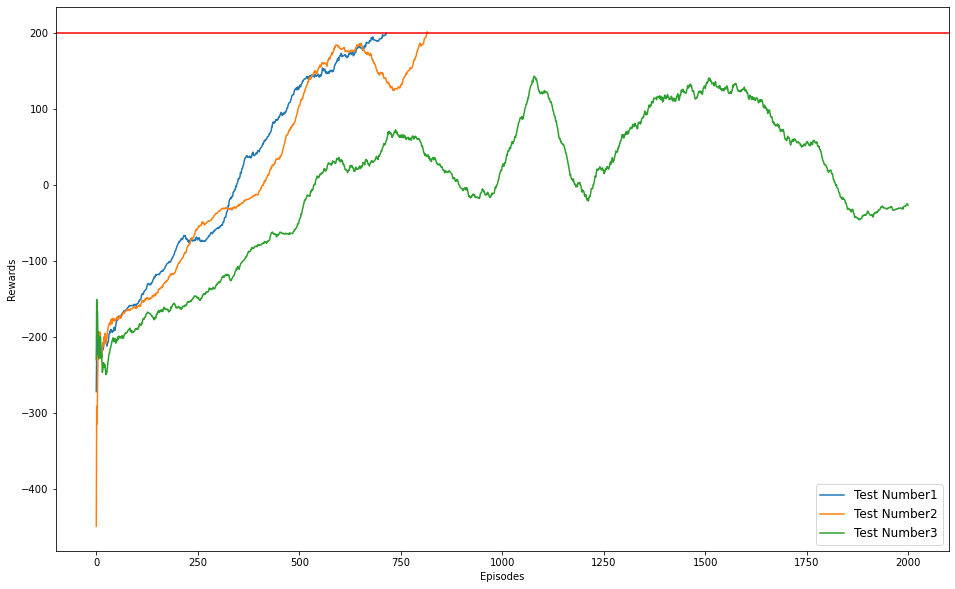

In [93]:
# plot de la recompensa de tots els agents en una mateixa gràfica
for idx,agent in enumerate(agents_lr):    
        plt.plot(agent.mean_training_rewards, label='Test Number' + str(idx + 1))

plt.rcParams['figure.figsize'] = [16, 10] 
plt.legend(prop={'size': 12})   
plt.rcParams.update({'font.size': 10})
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')        
plt.show()

Clarament hi ha un dels paràmetres de learning rate que funciona pitjor que els altres, concretament 0.0001 que no ha arribat a convergir

Anem a iterar ara amb DNN_UPD fixant el learning rate.

In [15]:
# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')

LEARNING_RATE = 0.0005     # Velocitat d'aprenentatge
DNN_UPD = [2, 3, 4, 5]  # Freqüència d'actualització de la xarxa neuronal

agents_upd = []
n_test = 1
# iteració per a buscar els millors paràmetres
for upd in DNN_UPD:
    print("Test Number: {}".format(n_test))
    print("DNN update: ", upd)
    agent = Agent(env, seed=0, learning_rate=LEARNING_RATE, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=upd)
    scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, EPS_DECAY, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
    agents_upd.append(agent)
    print("Mean reward: ", agent.mean_training_rewards[-1])
    print("Mean loss: ", agent.mean_update_loss[-1])
    print("Epsilon: ", agent.sync_eps[-1])
    print("Steps: ", agent.total_episodes)
    print("Total time: ", agent.total_time)
    print("===========================================================================================")
    n_test += 1    
                  
# tanquem l'entorn de gym
env.close()

Test Number: 1
DNN update:  2
Running on CPU
Training...
Episode 100	Mean Rewards: -154.49	Epsilon 0.6058	Time 0.25 minutes	
Episode 200	Mean Rewards: -92.88	Epsilon 0.367	Time 1.11 minutes			
Episode 300	Mean Rewards: -49.51	Epsilon 0.2223	Time 4.05 minutes	
Episode 400	Mean Rewards: 33.67	Epsilon 0.1347	Time 7.25 minutes		
Episode 500	Mean Rewards: 189.40	Epsilon 0.0816	Time 9.45 minutes	
Episode 510	Mean Rewards: 200.86	Epsilon 0.0776	Time 9.62 minutes	
Environment solved in 510 episodes!	Average Score: 200.86

Training finished.
Mean reward:  200.85960142471583
Mean loss:  11.18067
Epsilon:  0.07758382377679894
Steps:  510
Total time:  0:09:37.078524
Test Number: 2
DNN update:  3
Running on CPU
Training...
Episode 100	Mean Rewards: -163.84	Epsilon 0.6058	Time 0.16 minutes	
Episode 200	Mean Rewards: -142.49	Epsilon 0.367	Time 0.58 minutes		
Episode 300	Mean Rewards: -55.54	Epsilon 0.2223	Time 2.82 minutes		
Episode 400	Mean Rewards: -24.65	Epsilon 0.1347	Time 5.91 minutes	
Episode 5

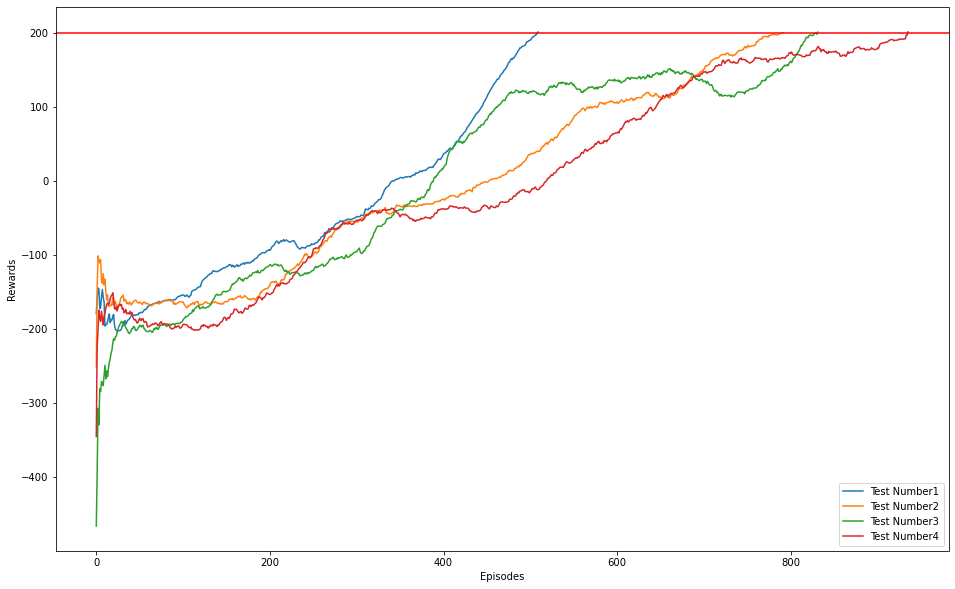

In [16]:
# plot de la recompensa de tots els agents en una mateixa gràfica
for idx,agent in enumerate(agents_upd):    
        plt.plot(agent.mean_training_rewards, label='Test Number' + str(idx + 1))

plt.legend()        
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')        
plt.show()

Els dos primers test són els que han convergit més ràpid. DNN update 2 i 3.

In [17]:
# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')

LEARNING_RATE = 0.0005     # Velocitat d'aprenentatge
DNN_UPD = 2              # Freqüència d'actualització de la xarxa neuronal
EPS_DECAY = [0.98, 0.99, 0.999]    # Valor de decaig de l'exploració

agents_eps = []
n_test = 1
# iteració per a buscar els millors paràmetres
for eps in EPS_DECAY:
    print("Test Number: {}".format(n_test))
    print("Epsilon decay: ", eps)
    agent = Agent(env, seed=0, learning_rate=LEARNING_RATE, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=DNN_UPD)
    scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, eps, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
    agents_eps.append(agent)
    print("Mean reward: ", agent.mean_training_rewards[-1])
    print("Mean loss: ", agent.mean_update_loss[-1])
    print("Epsilon: ", agent.sync_eps[-1])
    print("Steps: ", agent.total_episodes)
    print("Total time: ", agent.total_time)
    print("===========================================================================================")
    n_test += 1    
                  
# tanquem l'entorn de gym
env.close()

Test Number: 1
Epsilon decay:  0.98
Running on CPU
Training...
Episode 100	Mean Rewards: -131.08	Epsilon 0.1326	Time 1.21 minutes	
Episode 200	Mean Rewards: -32.95	Epsilon 0.0176	Time 3.39 minutes		
Episode 300	Mean Rewards: 90.18	Epsilon 0.01	Time 5.73 minutes				
Episode 400	Mean Rewards: 179.74	Epsilon 0.01	Time 7.21 minutes	
Episode 425	Mean Rewards: 202.10	Epsilon 0.01	Time 7.45 minutes	
Environment solved in 425 episodes!	Average Score: 202.10

Training finished.
Mean reward:  202.09909796643487
Mean loss:  8.626702
Epsilon:  0.01
Steps:  425
Total time:  0:07:27.044605
Test Number: 2
Epsilon decay:  0.99
Running on CPU
Training...
Episode 100	Mean Rewards: -149.96	Epsilon 0.366	Time 0.36 minutes	
Episode 200	Mean Rewards: -62.36	Epsilon 0.134	Time 2.92 minutes			
Episode 300	Mean Rewards: 72.61	Epsilon 0.049	Time 5.84 minutes			
Episode 400	Mean Rewards: 199.74	Epsilon 0.018	Time 7.4 minutes	s	
Episode 401	Mean Rewards: 200.63	Epsilon 0.0178	Time 7.41 minutes	
Environment solved

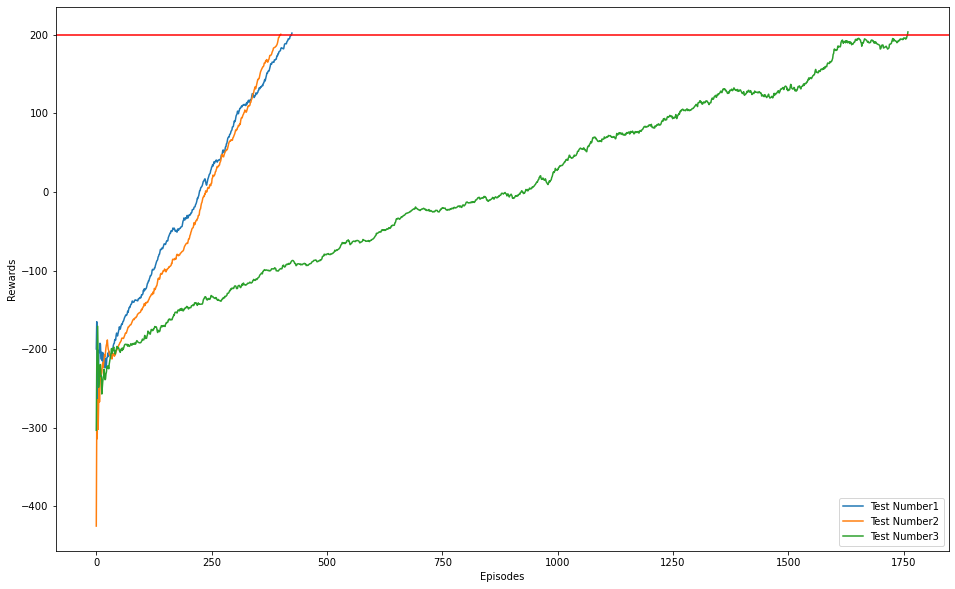

In [18]:
# plot de la recompensa de tots els agents en una mateixa gràfica
for idx,agent in enumerate(agents_eps):    
        plt.plot(agent.mean_training_rewards, label='Test Number' + str(idx + 1))

plt.legend()        
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')        
plt.show()

Amb els resultats eliminemt clarament el Test número 4 = 0.999. 

Ara farem l'estudi amb els millors paràmetres combinats.

In [19]:
LEARNING_RATE = [1e-3, 5e-4]
DNN_UPD = [2, 3]
EPS_DECAY = [0.995, 0.98, 0.99]

# per emmagatzemar tots els agents creats
agents_dqn = []
# número de test
n_test = 1
# iteració per a buscar els millors paràmetres
for lr in LEARNING_RATE:
    for upd in DNN_UPD:
        for eps in EPS_DECAY:
            print("Test Number: {} ".format(n_test))
            print("Learning rate: {}, DNN update: {}, Epsilon decay: {}".format(lr, upd, eps))
            agent = Agent(env, seed=0, learning_rate=lr, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=upd)
            scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, eps, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
            agents_dqn.append(agent)
            print("Mean reward: ", agent.mean_training_rewards[-1])
            print("Mean loss: ", agent.mean_update_loss[-1])
            print("Epsilon: ", agent.sync_eps[-1])
            print("Steps: ", agent.total_episodes)
            print("Total time: ", agent.total_time)
            print("===========================================================================================")
            n_test += 1    
                  
# tanquem l'entorn de gym
env.close()

Test Number: 1 
Learning rate: 0.001, DNN update: 2, Epsilon decay: 0.995
Running on CPU
Training...
Episode 100	Mean Rewards: -140.39	Epsilon 0.6058	Time 0.25 minutes	
Episode 200	Mean Rewards: -73.31	Epsilon 0.367	Time 0.95 minutes			
Episode 300	Mean Rewards: 14.69	Epsilon 0.2223	Time 3.33 minutes		
Episode 400	Mean Rewards: 157.31	Epsilon 0.1347	Time 5.17 minutes	
Episode 467	Mean Rewards: 200.83	Epsilon 0.0962	Time 5.99 minutes	
Environment solved in 467 episodes!	Average Score: 200.83

Training finished.
Mean reward:  200.83170317287338
Mean loss:  11.738695
Epsilon:  0.09624511776741324
Steps:  467
Total time:  0:05:59.462883
Test Number: 2 
Learning rate: 0.001, DNN update: 2, Epsilon decay: 0.98
Running on CPU
Training...
Episode 100	Mean Rewards: -141.81	Epsilon 0.1326	Time 1.0 minutes	
Episode 200	Mean Rewards: 9.69	Epsilon 0.0176	Time 3.89 minutes				
Episode 300	Mean Rewards: 187.49	Epsilon 0.01	Time 5.45 minutes		
Episode 316	Mean Rewards: 200.38	Epsilon 0.01	Time 5.56 mi

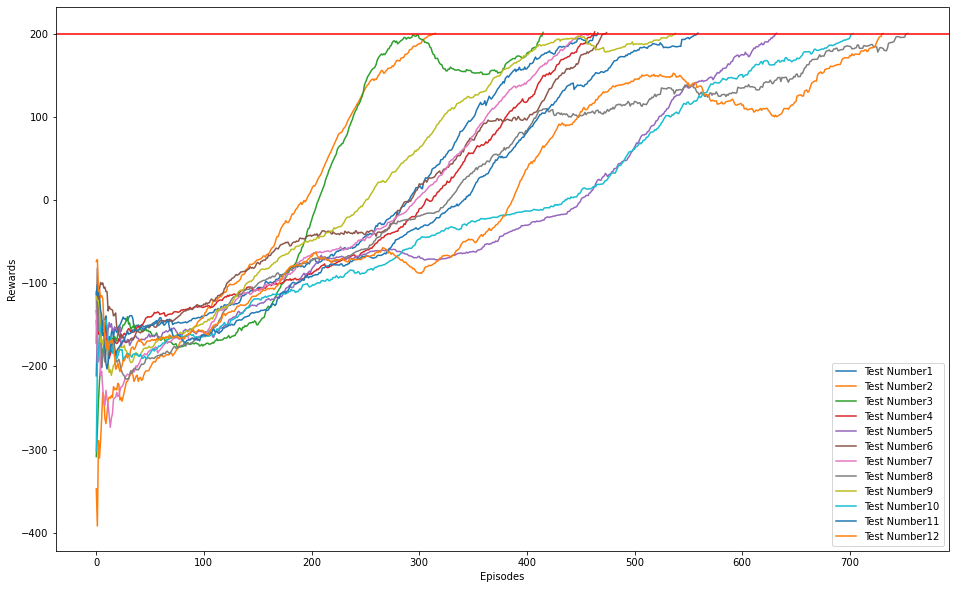

In [20]:
# plot de la recompensa de tots els agents en una mateixa gràfica
for idx,agent in enumerate(agents_dqn):    
        plt.plot(agent.mean_training_rewards, label='Test Number' + str(idx + 1))

plt.legend()        
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')        
plt.show()

Queda clar que hi han uns test que es degraden molt però anem a filtrar una mica més per tal de escollir bé els paràmetres.

Test Number: 1
Learning Rate: 0.001
DNN Update: 2
Epsilon decay: 0.995
Total episodes: 467
----------------------
Test Number: 2
Learning Rate: 0.001
DNN Update: 2
Epsilon decay: 0.98
Total episodes: 316
----------------------
Test Number: 3
Learning Rate: 0.001
DNN Update: 2
Epsilon decay: 0.99
Total episodes: 416
----------------------
Test Number: 4
Learning Rate: 0.001
DNN Update: 3
Epsilon decay: 0.995
Total episodes: 464
----------------------
Test Number: 6
Learning Rate: 0.001
DNN Update: 3
Epsilon decay: 0.99
Total episodes: 475
----------------------
Test Number: 7
Learning Rate: 0.0005
DNN Update: 2
Epsilon decay: 0.995
Total episodes: 460
----------------------
Test Number: 9
Learning Rate: 0.0005
DNN Update: 2
Epsilon decay: 0.99
Total episodes: 539
----------------------
Test Number: 11
Learning Rate: 0.0005
DNN Update: 3
Epsilon decay: 0.98
Total episodes: 560
----------------------


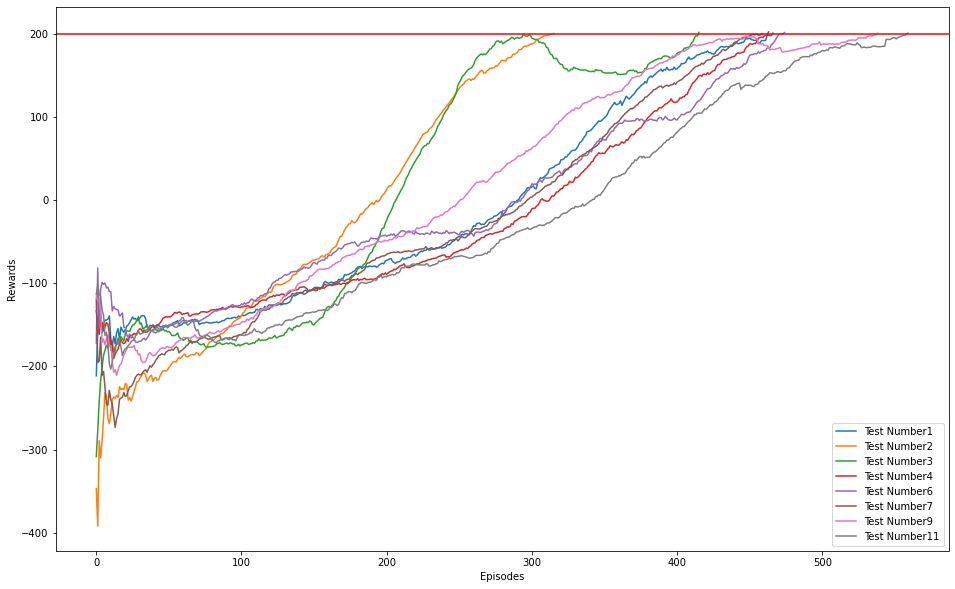

In [21]:
# plot de la recompensa de tots els agents en una mateixa gràfica
for idx,agent in enumerate(agents_dqn):    
        if (agent.total_episodes < 600):
            plt.plot(agent.mean_training_rewards, label='Test Number' + str(idx + 1))
            print("Test Number: " + str(idx + 1))
            print("Learning Rate: " + str(agent.learning_rate))
            print("DNN Update: " + str(agent.dnn_upd))
            print("Epsilon decay: " + str(agent.eps_decay))
            print("Total episodes: " + str(agent.total_episodes))
            print("----------------------")
            
plt.legend()        
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')        
plt.show()

Tenim resultats molt similars agafarem el del mínim nombre d'episodis realitzats.

In [22]:
from operator import itemgetter
agent_selected = min(agents_dqn, key=lambda x: x.total_episodes)
print("Learning Rate: " + str(agent_selected.learning_rate))
print("DNN Update: " + str(agent_selected.dnn_upd))
print("Epsilon decay: " + str(agent_selected.eps_decay))
print("Total episodes: " + str(agent_selected.total_episodes))

Learning Rate: 0.001
DNN Update: 2
Epsilon decay: 0.98
Total episodes: 316


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.3 (0.5 punts):</strong> Visualitzar-ne el comportament (a través de
gràfiques de les mètriques més oportunes).
</div>

In [23]:
def plot_rewards(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.training_rewards, label='Rewards')
        plt.plot(agent.mean_training_rewards, label='Mean Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

def plot_loss(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.mean_update_loss, label='Loss')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.legend(loc="upper left")
        plt.show()
        
def plot_epsilon(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.sync_eps, label='Epsilon')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.legend(loc="upper left")
        plt.show()

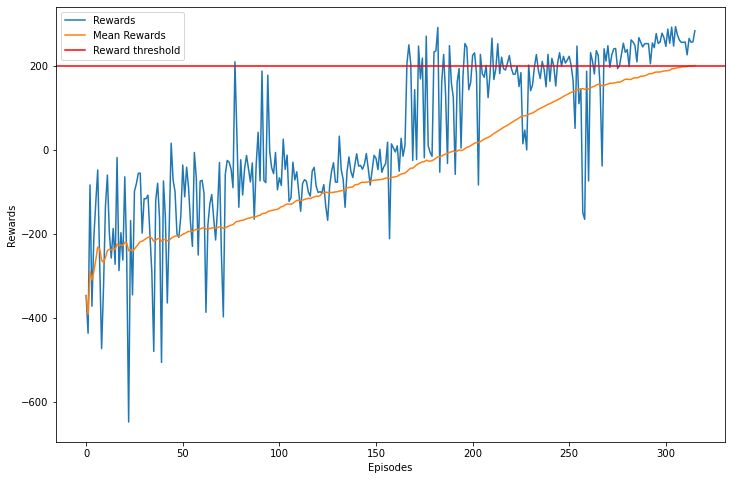

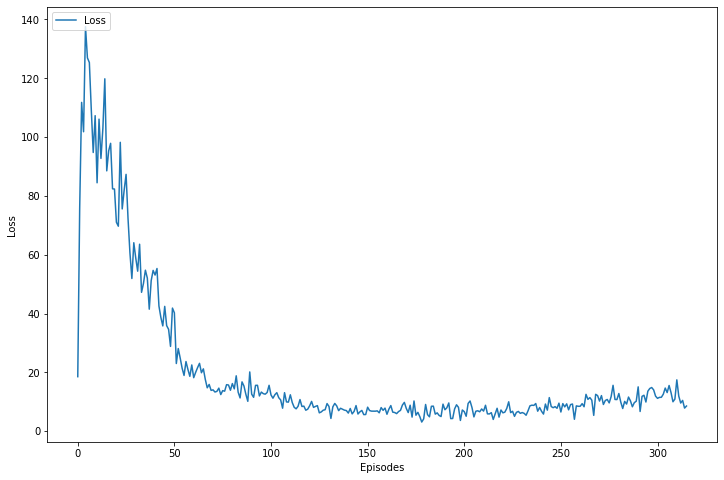

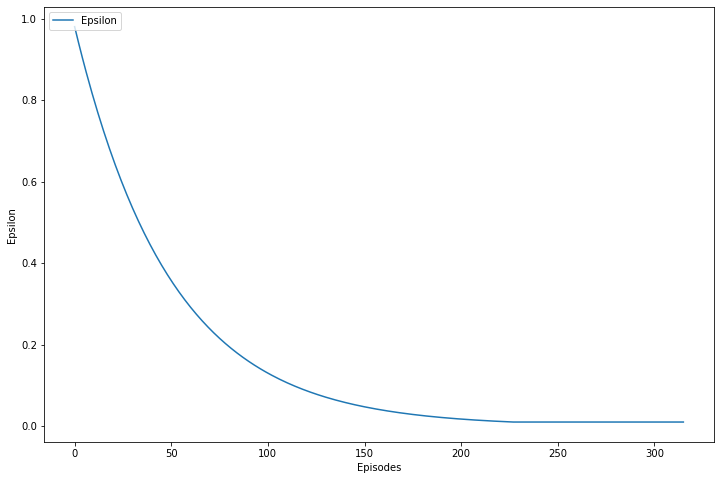

In [24]:
plot_rewards(agent_selected)
plot_loss(agent_selected)
plot_epsilon(agent_selected)

En els gràfics podem veure clarament com l'agent té un aprenentatge incremental des de l'inici de l'entrenament. En la gràfica de la pèrdua s'aprecia com els valors esperats contra els produïts a l'inici tenen molta diferència però conforme va millorant l'aprenentatge aquests es van reduïnt. També veiem com la epsilon del e-greedy arrencal amb el valor màxim i conforme augmenta l'entrenament va descendint fins al seu valor mínim.

Farem amb aquest agent 100 partidas per veure com es comporta. 

In [25]:
env = gym.make('LunarLander-v2')

def play_games(env, ag, num_games):    
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        env.reset()
        state = env.reset()           
        total_reward = 0
        done = False
        while not done:
            action = ag.get_action(state,eps=0.0)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    return total_reward_list      
          

In [26]:
total_reward_list = play_games(env, agent_selected, 100)

Episode 99/100.

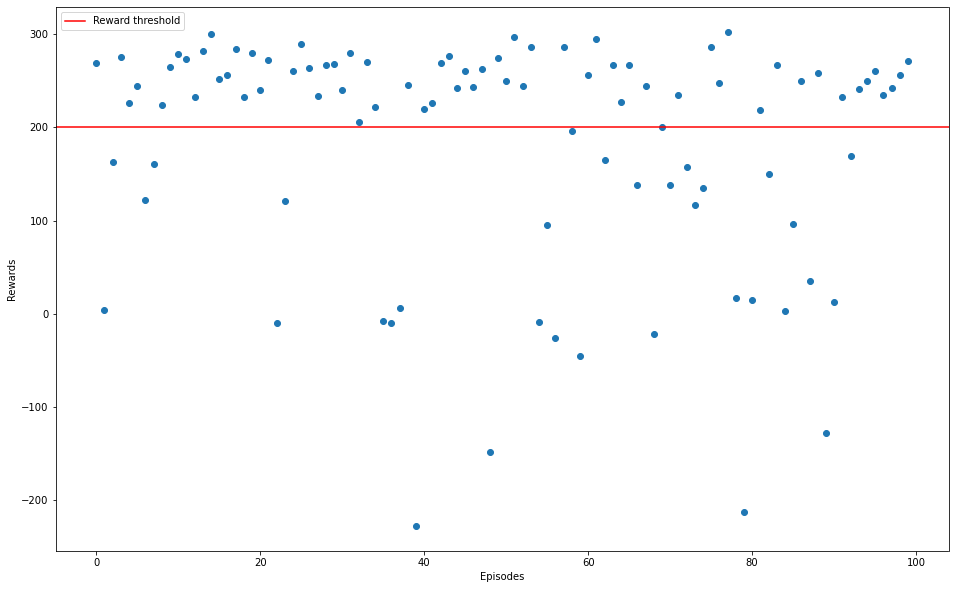

In [27]:
plt.scatter(range(len(total_reward_list)), total_reward_list, marker='o');
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.show()

In [94]:
print("Tenim una mitja de: {}".format(np.mean(total_reward_list)))
print("I la desviació estàndard és de: {}".format(np.std(total_reward_list)))

Tenim una mitja de: 97.70921950524954
I la desviació estàndard és de: 150.94040380269837


Amb l'algoritme DQN implementat tenim un molt bona convergencia i alhora sembla que està força estabilitzat. De les 100 proves realitzades només es veuen algunes poques que cauen per sota de 100 i la majoria es troben molt properes a 200.

Encara amb aquests bons valors anem a intentar trobar un amb més estabilitat fent el mateix amb tots el agents que hem entrenat i no basant-nos en els episodis que ha trigat a convergir.

In [29]:
# iterem sobre els agents i juguem 100 partides amb cada agent
for idx, agent_i in enumerate(agents_dqn):
    print("\nPlaying episodes for the dueling agent {}".format(idx + 1))
    total_rewards = play_games(env, agent_i, 100)    
    print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_rewards), np.std(total_rewards)))


Playing episodes for the dueling agent 1
Episode 99/100.Mean reward for agent 1: 214.0453234429932 +/- 78.1068831622971

Playing episodes for the dueling agent 2
Episode 99/100.Mean reward for agent 2: 210.9420419300313 +/- 90.35922521953268

Playing episodes for the dueling agent 3
Episode 99/100.Mean reward for agent 3: 173.11326846384873 +/- 106.54384777909411

Playing episodes for the dueling agent 4
Episode 99/100.Mean reward for agent 4: 232.41263312097843 +/- 60.56087198038042

Playing episodes for the dueling agent 5
Episode 99/100.Mean reward for agent 5: 195.2193623024128 +/- 115.61905328939677

Playing episodes for the dueling agent 6
Episode 99/100.Mean reward for agent 6: 243.92751115153558 +/- 29.705683873939112

Playing episodes for the dueling agent 7
Episode 99/100.Mean reward for agent 7: 195.0420557857089 +/- 89.13116217267411

Playing episodes for the dueling agent 8
Episode 99/100.Mean reward for agent 8: 210.32528159110046 +/- 70.80129896443286

Playing episodes 

In [30]:
print("Learning Rate: " + str(agents_dqn[5].learning_rate))
print("DNN Update: " + str(agents_dqn[5].dnn_upd))
print("Epsilon decay: " + str(agents_dqn[5].eps_decay))
print("Total episodes: " + str(agents_dqn[5].total_episodes))

Learning Rate: 0.001
DNN Update: 2
Epsilon decay: 0.99
Total episodes: 416


Podem dir que el més estable és el Agent 3 amb una mitja major i desviació menor. Repetim l'entrenament i mostrem els resultats.

In [101]:
total_reward_list_dqn = play_games(env, agents_dqn[5], 100)

Episode 99/100.

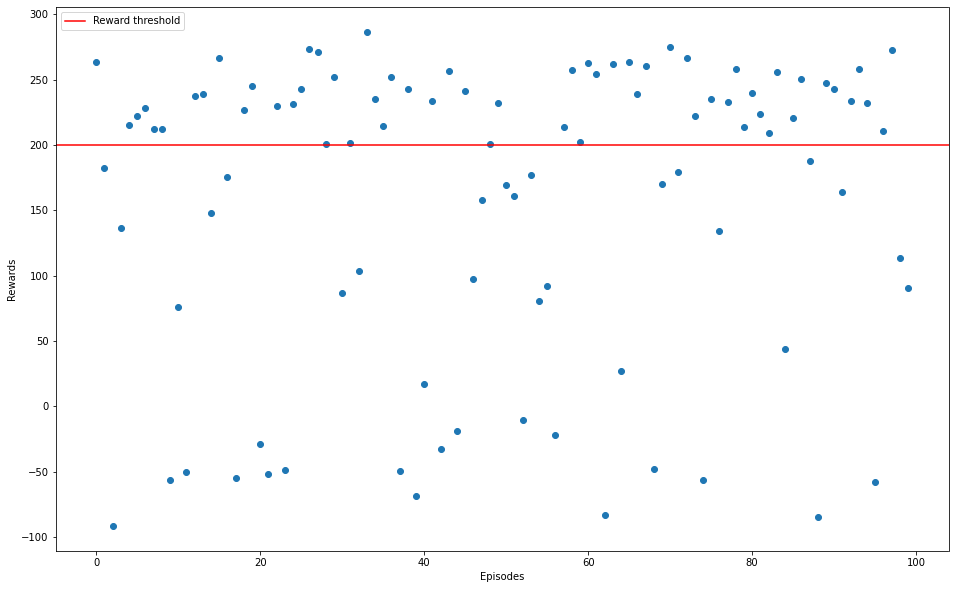

In [32]:
plt.scatter(range(len(total_reward_list_dqn)), total_reward_list_dqn, marker='o');
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.show()

## 6. Proposta de millora

En aquesta part es demana proposar una solució alternativa al problema de robòtica espacial que pugui ser més eficient respecte a allò que s'ha implementat anteriorment. 
Per assolir aquest objectiu, cal implementar un nou agent, basat en els algoritmes que hem vist al llarg de l’assignatura.

Es demana resoldre els 3 exercicis següents.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.1 (2 punts):</strong> Implementar l'agent identificat a l'entorn lunar-lander.
    
Justifiqueu les raons que han portat a provar aquest tipus d'observació entre les disponibles i perquè s'ha triat aquest tipus d'agent. Detalleu quins tipus de problemes s'espera que es puguin solucionar respecte a la implementació anterior
</div>

Per millorar el rendiment i/o estabilitat de l'agent anem a fer servir una xarxa Dueling DQN. En una DQN , es fa servir una única xarxa neuronal per calcular el valor Q per a cada acció en un estat donat com hem vist en l'exercici anterior. En canvi, en la Dueling DQN fem servir dues: una per calcular el valor d'estat i una altra per calcular l'avantatge d'acció (la diferència entre el valor Q d'una acció especifica i el valor de l'estat). Aquests dos valors es combinen en el forward per calcular el valor Q final per a cada acció.

Primer definim la dueling amb capes de 64 neurones en la transició de la capa d'entrada cap a les capes de entrada de l'avantatge i de valor.

In [33]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

class DuelingDQNetwork(nn.Module):
    """ Deep Q-Network model  per a l'entrenament de l'agent DQN """
 
    def __init__(self, n_state, n_action, seed, n_layer1=64, n_layer2=64, n_layer3=64):
        """
        Inicialització de la xarxa neuronal
        Params
        =======
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            n_layer1 (int): Nombre de nodes en la primera capa oculta
            n_layer2 (int): Nombre de nodes en la segona capa oculta
            seed (int): Random seed per a inicialitzar els valors aleatoris
        """
        super(DuelingDQNetwork, self).__init__()
        self.seed = T.manual_seed(seed)
        self.fl1 = nn.Linear(n_state, n_layer1)
        self.fl2 = nn.Linear(n_layer1, n_layer2)

        self.advantage1 = nn.Linear(n_layer2, n_layer3)
        self.advantage2 = nn.Linear(n_layer3, n_action)

        self.value1 = nn.Linear(n_layer2, n_layer3)
        self.value2 = nn.Linear(n_layer3, 1)

    def forward(self, state):
        """
        Forward pass de la xarxa neuronal amb una capa oculta de 64 nodes i una capa de sortida de 4 nodes (una per cada acció)
        amb activació ReLU en les dues capes ocultes i activació lineal en la capa de sortida 
        """
        state = F.relu(self.fl1(state))
        state = F.relu(self.fl2(state))

        advantage = F.relu(self.advantage1(state))
        advantage = self.advantage2(advantage)

        value = F.relu(self.value1(state))
        value = self.value2(value)

        return value + advantage - advantage.mean()

Per implementar l'agent reaprofitem tot el codi de la DQN fent servir la herencia i sobreescrivim  les xarxes neuronals a l'inicialitzar.

In [81]:
class DuelingAgent(Agent):
    """ Agent que interactua amb l'entorn i apren a través de DQN"""    
    """ Es sobreescriuen els mètodes de l'agent DQN per a que utilitzi la xarxa neuronal Dueling """
    """ Fem servir la herencia per a que l'agent Dueling hereti de l'agent DQN """
   
    def __init__(self, env, seed, learning_rate= 1e-3, gamma=0.99, tau=1e-3, buffer_size=100000, batch_size=64, dnn_upd=4):
        """ Inicialitza l'agent per a l'aprenentatge per DQN
            L'agent inicialitza la xarxa neuronal local i target, el buffer de memòria i l'optimitzador    
        Params
        ======
            env: Entorn de gym
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            seed (int): Random seed per a inicialitzar els valors aleatoris
            learning_rate (float): Velocitat d'aprenentatge
            gamma (float): Valor gamma de l'equació de Bellman
            tau (float): Valor de tau per a soft update del target network
            buffer_size (int): Màxima capacitat del buffer
            batch_size (int): Conjunt a agafar del buffer per a la xarxa neuronal     
            dnn_upd (int): Freqüència d'actualització de la xarxa neuronal       
        """
        super().__init__(env, seed, learning_rate, gamma, tau, buffer_size, batch_size, dnn_upd)
        self.__initialize_networks()

       
    def __initialize_networks(self):
        print("Sobreescrivim la xarxa neuronal local i target per a que siguin de tipus Dueling")        
        # Sobreescrivim la xarxa neuronal local i target per a que siguin de tipus Dueling
        self.qnetwork_local = DuelingDQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        self.qnetwork_target = DuelingDQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        # Inicialització de l'optimitzador
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.learning_rate)

        # Inicialització del buffer de memòria
        self.memory = ReplayBuffer(self.n_action, self.buffer_size, self.batch_size, self.seed)
    
        # Inicialització del comptador de pasos per a l'actualització de la xarxa neuronal
        self.t_step = 0

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.2 (2 punts):</strong> Entrenar l'agent identificat i cercar els valors dels hiperparàmetres que obtinguin el
rendiment 'òptim' de l'agent.
</div>

In [35]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3              # Valor de tau per a soft update del target network

N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 200  # Valor de recompensa per a considerar l'entrenament com a completat

# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')
# inicialització de l'agent amb els paràmetres de l'exercici
LEARNING_RATE = [1e-3, 5e-4]              # Velocitat d'aprenentatge
DNN_UPD = [2, 3]                       # Freqüència d'actualització de la xarxa neuronal
EPS_DECAY = [0.995, 0.98, 0.99]                 # Decaiment de l'exploració

dueling_agents = []
n_test = 1
# iteració per a buscar els millors paràmetres
for lr in LEARNING_RATE:
    for upd in DNN_UPD:
        for eps in EPS_DECAY:
            print("Test Number: {} ".format(n_test))
            print("Learning rate: {}, DNN update: {}, Epsilon decay: {}".format(lr, upd, eps))
            duelingAgent = DuelingAgent(env, seed=0, learning_rate=lr, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=upd)
            duelingAgent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, eps, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
            dueling_agents.append(duelingAgent)
            print("Mean reward: ", duelingAgent.mean_training_rewards[-1])
            print("Mean loss: ", duelingAgent.mean_update_loss[-1])
            print("Epsilon: ", duelingAgent.sync_eps[-1])
            print("Steps: ", duelingAgent.total_episodes)
            print("Total time: ", duelingAgent.total_time)
            print("===========================================================================================")
            n_test += 1    
                  
# tanquem l'entorn de gym
env.close()

Test Number: 1 
Learning rate: 0.001, DNN update: 2, Epsilon decay: 0.995
Running on CPU
Sobreescrivim la xarxa neuronal local i target per a que siguin de tipus Dueling
Training...
Episode 100	Mean Rewards: -129.48	Epsilon 0.6058	Time 0.33 minutes	
Episode 200	Mean Rewards: -74.64	Epsilon 0.367	Time 1.94 minutes			
Episode 300	Mean Rewards: -9.84	Epsilon 0.2223	Time 4.26 minutes		
Episode 400	Mean Rewards: 128.40	Epsilon 0.1347	Time 6.42 minutes	
Episode 458	Mean Rewards: 203.31	Epsilon 0.1007	Time 7.27 minutes	
Environment solved in 458 episodes!	Average Score: 203.31

Training finished.
Mean reward:  203.3119162209613
Mean loss:  14.6302595
Epsilon:  0.10068643904747315
Steps:  458
Total time:  0:07:16.161021
Test Number: 2 
Learning rate: 0.001, DNN update: 2, Epsilon decay: 0.98
Running on CPU
Sobreescrivim la xarxa neuronal local i target per a que siguin de tipus Dueling
Training...
Episode 100	Mean Rewards: -159.35	Epsilon 0.1326	Time 1.68 minutes	
Episode 200	Mean Rewards: -99

Episode 100	Mean Rewards: -138.76	Epsilon 0.1326	Time 1.02 minutes	
Episode 200	Mean Rewards: -11.42	Epsilon 0.0176	Time 3.99 minutes		
Episode 300	Mean Rewards: 149.91	Epsilon 0.01	Time 6.73 minutes			
Episode 400	Mean Rewards: 161.10	Epsilon 0.01	Time 8.21 minutes	
Episode 500	Mean Rewards: 170.44	Epsilon 0.01	Time 9.29 minutes	
Episode 536	Mean Rewards: 202.55	Epsilon 0.01	Time 9.64 minutes	
Environment solved in 536 episodes!	Average Score: 202.55

Training finished.
Mean reward:  202.55461399401477
Mean loss:  10.718399
Epsilon:  0.01
Steps:  536
Total time:  0:09:38.402232
Test Number: 12 
Learning rate: 0.0005, DNN update: 3, Epsilon decay: 0.99
Running on CPU
Sobreescrivim la xarxa neuronal local i target per a que siguin de tipus Dueling
Training...
Episode 100	Mean Rewards: -179.13	Epsilon 0.366	Time 0.42 minutes	
Episode 200	Mean Rewards: -62.90	Epsilon 0.134	Time 3.41 minutes			
Episode 300	Mean Rewards: 15.07	Epsilon 0.049	Time 7.07 minutes			
Episode 400	Mean Rewards: 63.

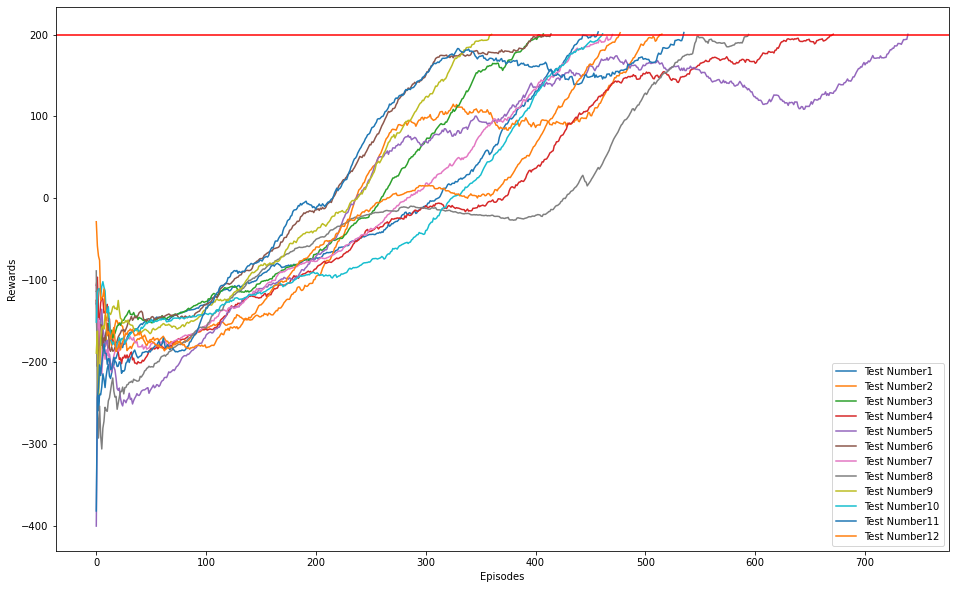

In [36]:
# plot de la recompensa de tots els agents en una mateixa gràfica
for idx,dueling_agent in enumerate(dueling_agents):    
        plt.plot(dueling_agent.mean_training_rewards, label='Test Number' + str(idx + 1))

plt.legend()        
plt.axhline(dueling_agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')        
plt.show()

Veiem que tots han convergit però anem a analitzar el que ha tingut una convergència amb menys passes.

In [37]:
dueling_agent_selected = min(dueling_agents, key=lambda x: x.total_episodes)
print("Learning Rate: " + str(dueling_agent_selected.learning_rate))
print("DNN Update: " + str(dueling_agent_selected.dnn_upd))
print("Epsilon decay: " + str(dueling_agent_selected.eps_decay))
print("Total episodes: " + str(dueling_agent_selected.total_episodes))

Learning Rate: 0.0005
DNN Update: 2
Epsilon decay: 0.99
Total episodes: 361


In [38]:
env = gym.make('LunarLander-v2')

def play_games(env, ag, num_games):    
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        env.reset()
        state = env.reset()           
        total_reward = 0
        done = False
        while not done:
            action = ag.get_action(state,eps=0.0)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    return total_reward_list      
          

def plot_rewards_min(agent, total_reward_list):
        plt.figure(figsize=(12,8))
        plt.plot(total_reward_list, label='Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

total_reward_list_dueling = play_games(env, dueling_agent_selected, 100)

Episode 99/100.

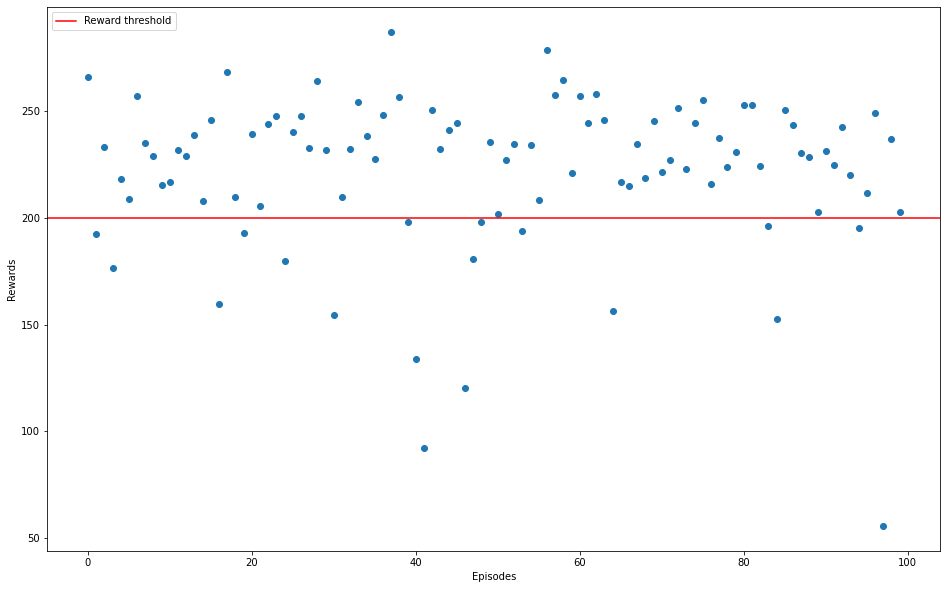

In [39]:
plt.scatter(range(len(total_reward_list_dueling)), total_reward_list_dueling, marker='o');
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.show()

In [40]:
print("Tenim una mitja de: {}".format(np.mean(total_reward_list_dueling)))
print("I la desviació estàndard és de: {}".format(np.std(total_reward_list_dueling)))

Tenim una mitja de: 222.58386602544738
I la desviació estàndard és de: 36.44477899868835


Visualment veiem que tenim alguns punts per sota dels 200 però el rendiment és molt millor que no pas l'algoritme DQN. Podem dir que aquest algoritme aconsegueix millor estabilitat en els resultats.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.3 (2 punts):</strong> Analitzar el comportament de l'agent entrenat a l'entorn de prova i comparar-lo amb
l'agent implementat en el punt 2 (a través de gràfiques de les mètriques més oportunes).
</div>

**Comparació entre els models**:

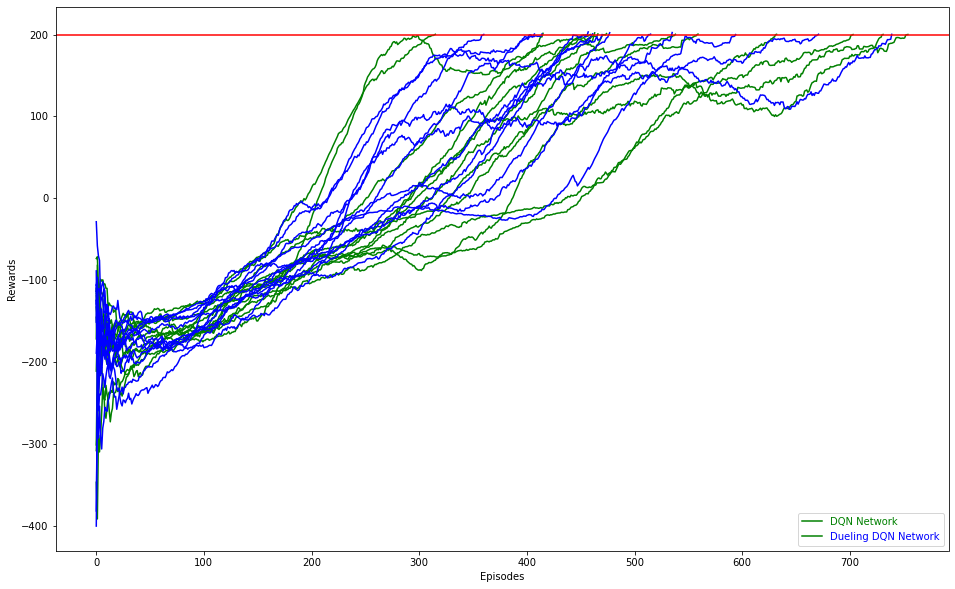

In [41]:
for idx,agent in enumerate(agents_dqn):    
        plt.plot(agent.mean_training_rewards,color='green', label='DQN Network')

for idx,dueling_agent in enumerate(dueling_agents):    
        plt.plot(dueling_agent.mean_training_rewards,color='blue', label='Dueling DQN Network')

plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')

plt.gca().legend(['DQN Network','Dueling DQN Network'], loc="lower right", labelcolor=['green', 'blue'])
plt.show()

Si comparem els passos per arribar a convergir no veiem que hagi anat molt millor amb Dueling DQN Network. El motiu pot ser que el DQN ja tenia una convergencia força acurada i és dificil de millorar. 

In [114]:
env = gym.make('LunarLander-v2')

def play_games(env, ag, num_games):    
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        env.reset()
        state = env.reset()           
        total_reward = 0
        done = False
        while not done:
            action = ag.get_action(state,eps=0.0)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    return total_reward_list      
          

total_reward_list_dueling = play_games(env, dueling_agent_selected, 100)

Episode 99/100.

Ara farem com hem fet amb DQN i jugarem 100 partides amb cada un dels agents Dueling que hem entrenat.

In [43]:
# iterem sobre els agents i juguem 100 partides amb cada agent
for idx, agent_i in enumerate(dueling_agents):
    print("\nPlaying episodes for the dueling agent {}".format(idx + 1))
    total_rewards = play_games(env, agent_i, 100)    
    print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_rewards), np.std(total_rewards)))


Playing episodes for the dueling agent 1
Episode 99/100.Mean reward for agent 1: 246.27541437387433 +/- 43.11315667785334

Playing episodes for the dueling agent 2
Episode 99/100.Mean reward for agent 2: 225.51784197615035 +/- 97.22263891826475

Playing episodes for the dueling agent 3
Episode 99/100.Mean reward for agent 3: 215.40264233930532 +/- 74.29882990023883

Playing episodes for the dueling agent 4
Episode 99/100.Mean reward for agent 4: 216.88753707294572 +/- 79.76542974804077

Playing episodes for the dueling agent 5
Episode 99/100.Mean reward for agent 5: 98.90271083419681 +/- 168.60120735246417

Playing episodes for the dueling agent 6
Episode 99/100.Mean reward for agent 6: 100.81095888260415 +/- 153.72487206367992

Playing episodes for the dueling agent 7
Episode 99/100.Mean reward for agent 7: 249.26442134202674 +/- 57.71180220358665

Playing episodes for the dueling agent 8
Episode 99/100.Mean reward for agent 8: 244.2142244810736 +/- 42.845787318568064

Playing episod

El millor agent Dueling no és pas el que havia convergit més ràpid sino que és el Agent que té una mitjana i desviació estandard en els resultats molt millors que no pas els altres.

Si el comparem amb el millor del model DQN.

In [100]:
print("Learning Rate: " + str(dueling_agents[0].learning_rate))
print("DNN Update: " + str(dueling_agents[0].dnn_upd))
print("Epsilon decay: " + str(dueling_agents[0].eps_decay))
print("Total episodes: " + str(dueling_agents[0].total_episodes))

total_reward_list_dueling = play_games(env, dueling_agents[0], 100)

print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_reward_list_dueling), np.std(total_reward_list_dueling)))

Learning Rate: 0.001
DNN Update: 2
Epsilon decay: 0.995
Total episodes: 458
Episode 99/100.Mean reward for agent 3: 243.90418265755582 +/- 49.06251116538986


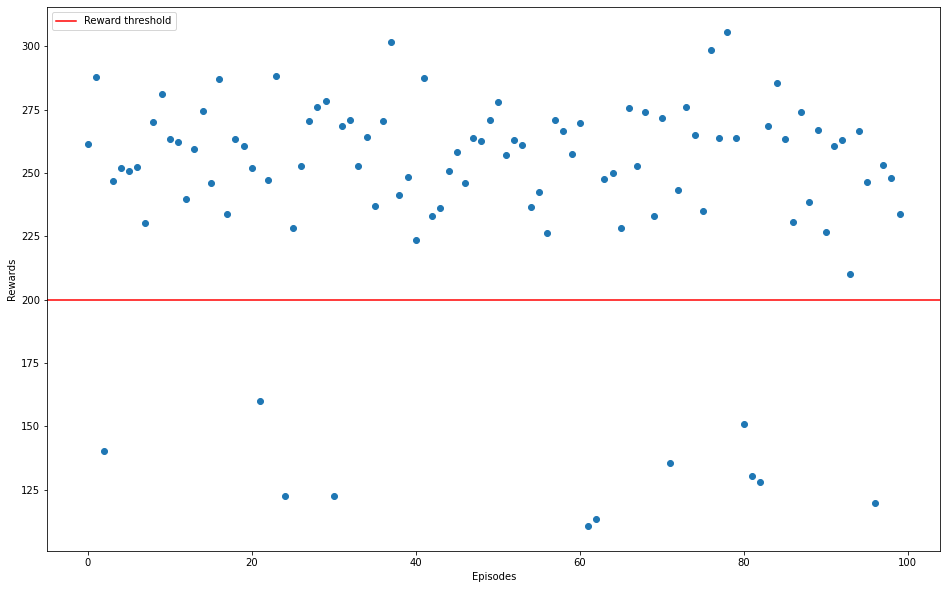

In [45]:
plt.scatter(range(len(total_reward_list_dueling)), total_reward_list_dueling, marker='o');
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.show()

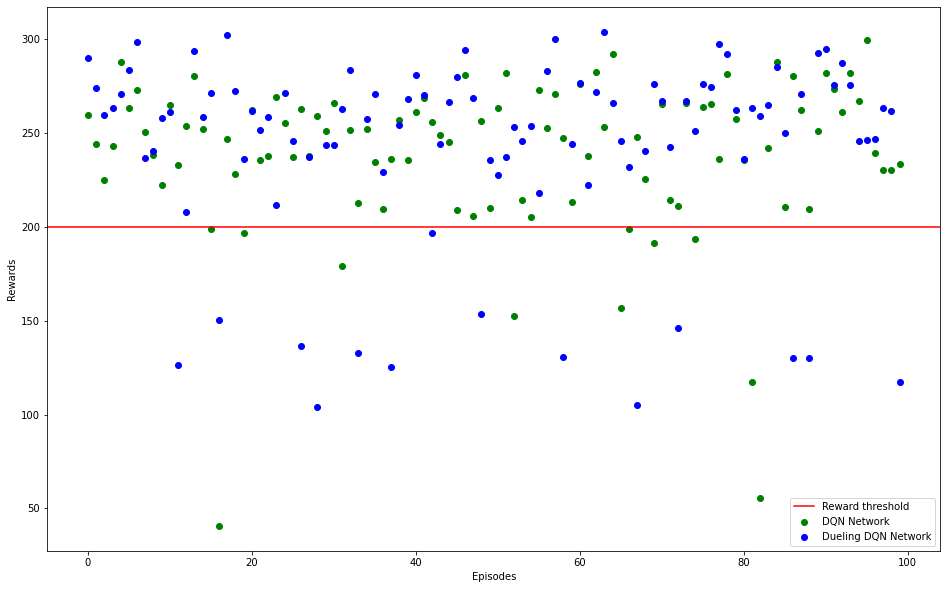

In [104]:
plt.scatter(range(len(total_reward_list_dqn)), total_reward_list_dqn, marker='o', c="green");
plt.scatter(range(len(total_reward_list_dueling)), total_reward_list_dueling, marker='o', c="blue");
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(['Reward threshold', 'DQN Network','Dueling DQN Network'], loc="lower right")
plt.show()

Realment no podem dir que hem aconseguit una gran millora entre la Dueling DQN i la DQN Network encara que si que tenim millors valors en la Dueling i sembla que és més estable.

Ara anem a “forçar” les xarxes possant el valor de threshold a 250 en comptes de 200. Entrenem de nou diferents agents i cerquem quins tenen millors resultats. 

In [47]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3              # Valor de tau per a soft update del target network
N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 250  # Valor de recompensa per a considerar l'entrenament com a completat

LEARNING_RATE = [1e-3, 5e-4]
DNN_UPD = [2, 3]
EPS_DECAY = [0.98, 0.99]

# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')

# per emmagatzemar tots els agents creats
agents_dqn_v2 = []
# número de test
n_test = 1
# iteració per a buscar els millors paràmetres
for lr in LEARNING_RATE:
    for upd in DNN_UPD:
        for eps in EPS_DECAY:
            print("Test Number: {} ".format(n_test))
            print("Learning rate: {}, DNN update: {}, Epsilon decay: {}".format(lr, upd, eps))
            agent = Agent(env, seed=0, learning_rate=lr, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=upd)
            scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, eps, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
            agents_dqn_v2.append(agent)
            print("Mean reward: ", agent.mean_training_rewards[-1])
            print("Mean loss: ", agent.mean_update_loss[-1])
            print("Epsilon: ", agent.sync_eps[-1])
            print("Steps: ", agent.total_episodes)
            print("Total time: ", agent.total_time)
            print("===========================================================================================")
            n_test += 1    
                  
# tanquem l'entorn de gym
env.close()

Test Number: 1 
Learning rate: 0.001, DNN update: 2, Epsilon decay: 0.98
Running on CPU
Training...
Episode 100	Mean Rewards: -146.73	Epsilon 0.1326	Time 1.15 minutes	
Episode 200	Mean Rewards: -37.29	Epsilon 0.0176	Time 4.69 minutes		
Episode 300	Mean Rewards: 114.17	Epsilon 0.01	Time 7.29 minutes	s	
Episode 400	Mean Rewards: 164.82	Epsilon 0.01	Time 8.69 minutes	
Episode 500	Mean Rewards: 231.24	Epsilon 0.01	Time 9.91 minutes	
Episode 600	Mean Rewards: 223.85	Epsilon 0.01	Time 10.95 minutes	
Episode 700	Mean Rewards: 172.97	Epsilon 0.01	Time 12.04 minutes	
Episode 800	Mean Rewards: 230.59	Epsilon 0.01	Time 13.01 minutes	
Episode 900	Mean Rewards: 234.07	Epsilon 0.01	Time 13.84 minutes	
Episode 1000	Mean Rewards: 201.47	Epsilon 0.01	Time 15.0 minutes	
Episode 1100	Mean Rewards: 195.81	Epsilon 0.01	Time 16.18 minutes	
Episode 1200	Mean Rewards: 232.82	Epsilon 0.01	Time 17.04 minutes	
Episode 1300	Mean Rewards: 204.76	Epsilon 0.01	Time 17.79 minutes	
Episode 1400	Mean Rewards: 215.33	Ep

Episode 100	Mean Rewards: -173.25	Epsilon 0.366	Time 0.27 minutes	
Episode 200	Mean Rewards: -123.76	Epsilon 0.134	Time 2.03 minutes		
Episode 300	Mean Rewards: -30.96	Epsilon 0.049	Time 5.29 minutes			
Episode 400	Mean Rewards: 32.51	Epsilon 0.018	Time 8.17 minutes			
Episode 500	Mean Rewards: 184.44	Epsilon 0.01	Time 9.85 minutes			
Episode 600	Mean Rewards: 192.79	Epsilon 0.01	Time 11.48 minutes	
Episode 700	Mean Rewards: 176.66	Epsilon 0.01	Time 12.55 minutes	
Episode 800	Mean Rewards: 130.27	Epsilon 0.01	Time 13.57 minutes	
Episode 900	Mean Rewards: 168.91	Epsilon 0.01	Time 14.61 minutes	
Episode 1000	Mean Rewards: 151.88	Epsilon 0.01	Time 15.61 minutes	
Episode 1100	Mean Rewards: 179.47	Epsilon 0.01	Time 16.47 minutes	
Episode 1200	Mean Rewards: 188.39	Epsilon 0.01	Time 17.44 minutes	
Episode 1300	Mean Rewards: 196.30	Epsilon 0.01	Time 18.37 minutes	
Episode 1400	Mean Rewards: 198.65	Epsilon 0.01	Time 19.32 minutes	
Episode 1500	Mean Rewards: 223.32	Epsilon 0.01	Time 20.16 minute

In [48]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3              # Valor de tau per a soft update del target network
N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 250  # Valor de recompensa per a considerar l'entrenament com a completat

LEARNING_RATE = [1e-3, 5e-4]             # Velocitat d'aprenentatge
DNN_UPD = [2, 3]                         # Freqüència d'actualització de la xarxa neuronal
EPS_DECAY = [0.98, 0.99]                 # Decaiment de l'exploració

# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')

dueling_agents_2 = []
n_test = 1
# iteració per a buscar els millors paràmetres
for lr in LEARNING_RATE:
    for upd in DNN_UPD:
        for eps in EPS_DECAY:
            print("Test Number: {} ".format(n_test))
            print("Learning rate: {}, DNN update: {}, Epsilon decay: {}".format(lr, upd, eps))
            duelingAgent = DuelingAgent(env, seed=0, learning_rate=lr, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=upd)
            duelingAgent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, eps, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
            dueling_agents_2.append(duelingAgent)
            print("Mean reward: ", duelingAgent.mean_training_rewards[-1])
            print("Mean loss: ", duelingAgent.mean_update_loss[-1])
            print("Epsilon: ", duelingAgent.sync_eps[-1])
            print("Steps: ", duelingAgent.total_episodes)
            print("Total time: ", duelingAgent.total_time)
            print("===========================================================================================")
            n_test += 1    
                  
# tanquem l'entorn de gym
env.close()

Test Number: 1 
Learning rate: 0.001, DNN update: 2, Epsilon decay: 0.98
Running on CPU
Sobreescrivim la xarxa neuronal local i target per a que siguin de tipus Dueling
Training...
Episode 100	Mean Rewards: -195.11	Epsilon 0.1326	Time 1.02 minutes	
Episode 200	Mean Rewards: 1.17	Epsilon 0.0176	Time 4.46 minutes				
Episode 300	Mean Rewards: 68.74	Epsilon 0.01	Time 7.53 minutes	s	
Episode 400	Mean Rewards: 172.73	Epsilon 0.01	Time 9.33 minutes	
Episode 500	Mean Rewards: 236.77	Epsilon 0.01	Time 10.38 minutes	
Episode 600	Mean Rewards: 225.46	Epsilon 0.01	Time 11.48 minutes	
Episode 700	Mean Rewards: 217.86	Epsilon 0.01	Time 12.72 minutes	
Episode 800	Mean Rewards: 210.93	Epsilon 0.01	Time 13.81 minutes	
Episode 900	Mean Rewards: 205.99	Epsilon 0.01	Time 14.77 minutes	
Episode 1000	Mean Rewards: 137.76	Epsilon 0.01	Time 15.81 minutes	
Episode 1100	Mean Rewards: 240.88	Epsilon 0.01	Time 16.84 minutes	
Episode 1200	Mean Rewards: 229.36	Epsilon 0.01	Time 17.93 minutes	
Episode 1251	Mean Rew

Episode 100	Mean Rewards: -190.89	Epsilon 0.366	Time 0.85 minutes	
Episode 200	Mean Rewards: -63.18	Epsilon 0.134	Time 5.03 minutes			
Episode 300	Mean Rewards: -72.41	Epsilon 0.049	Time 9.52 minutes			
Episode 400	Mean Rewards: -19.55	Epsilon 0.018	Time 13.46 minutes		
Episode 500	Mean Rewards: -11.83	Epsilon 0.01	Time 17.71 minutes	s	
Episode 600	Mean Rewards: -6.16	Epsilon 0.01	Time 21.81 minutes		
Episode 700	Mean Rewards: 109.52	Epsilon 0.01	Time 24.57 minutes	
Episode 800	Mean Rewards: 231.56	Epsilon 0.01	Time 25.53 minutes	
Episode 900	Mean Rewards: 224.55	Epsilon 0.01	Time 26.41 minutes	
Episode 1000	Mean Rewards: 221.42	Epsilon 0.01	Time 27.25 minutes	
Episode 1100	Mean Rewards: 220.67	Epsilon 0.01	Time 28.01 minutes	
Episode 1200	Mean Rewards: 208.38	Epsilon 0.01	Time 28.88 minutes	
Episode 1300	Mean Rewards: 237.73	Epsilon 0.01	Time 29.59 minutes	
Episode 1400	Mean Rewards: 246.92	Epsilon 0.01	Time 30.38 minutes	
Episode 1431	Mean Rewards: 250.10	Epsilon 0.01	Time 30.55 minu

Comparem els models en steps per a aconseguir els objectius del nous rewards.

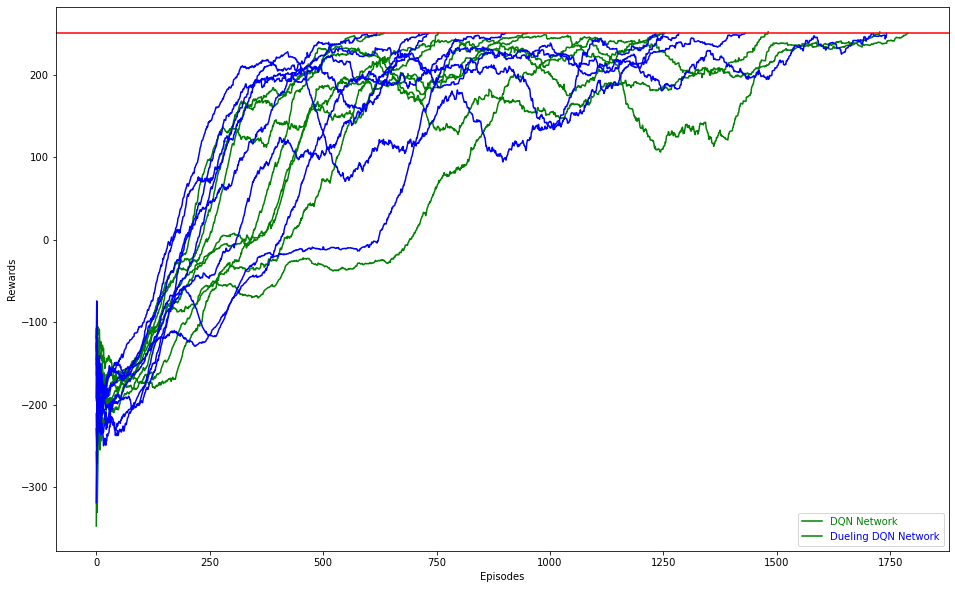

In [58]:
for idx,agent in enumerate(agents_dqn_v2):    
        plt.plot(agent.mean_training_rewards,color='green', label='DQN Network')

for idx,dueling_agent in enumerate(dueling_agents_2):    
        plt.plot(dueling_agent.mean_training_rewards,color='blue', label='Dueling DQN Network')

plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')

plt.gca().legend(['DQN Network','Dueling DQN Network'], loc="lower right", labelcolor=['green', 'blue'])
plt.show()

I juguem 100 partides amb cada un dels agents entrenats per els models.

In [59]:
# iterem sobre els agents i juguem 100 partides amb cada agent
for idx, agent_i in enumerate(agents_dqn_v2):
    print("\nPlaying episodes for the DQN agent {}".format(idx + 1))
    total_rewards = play_games(env, agent_i, 100)    
    print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_rewards), np.std(total_rewards)))


Playing episodes for the DQN agent 1
Episode 99/100.Mean reward for agent 1: 265.36002935187713 +/- 18.647252633665314

Playing episodes for the DQN agent 2
Episode 99/100.Mean reward for agent 2: 242.0169302106801 +/- 78.32441972357532

Playing episodes for the DQN agent 3
Episode 99/100.Mean reward for agent 3: 243.22542901195067 +/- 39.7592814654898

Playing episodes for the DQN agent 4
Episode 99/100.Mean reward for agent 4: 226.30832491323451 +/- 62.343779272281886

Playing episodes for the DQN agent 5
Episode 99/100.Mean reward for agent 5: 251.61378379321934 +/- 36.95234394113214

Playing episodes for the DQN agent 6
Episode 99/100.Mean reward for agent 6: 265.5808683790174 +/- 25.03708934332071

Playing episodes for the DQN agent 7
Episode 99/100.Mean reward for agent 7: 252.97501970561436 +/- 29.81654899722588

Playing episodes for the DQN agent 8
Episode 99/100.Mean reward for agent 8: 246.80455680031187 +/- 50.67297569492771


In [109]:
# iterem sobre els agents i juguem 100 partides amb cada agent
for idx, agent_i in enumerate(dueling_agents_2):
    print("\nPlaying episodes for the dueling agent {}".format(idx + 1))
    total_rewards = play_games(env, agent_i, 100)    
    print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_rewards), np.std(total_rewards)))


Playing episodes for the dueling agent 1
Episode 99/100.Mean reward for agent 1: 250.89160728918574 +/- 49.7199773341093

Playing episodes for the dueling agent 2
Episode 99/100.Mean reward for agent 2: 250.77088869370033 +/- 55.029900596611554

Playing episodes for the dueling agent 3
Episode 99/100.Mean reward for agent 3: 249.17992998374706 +/- 44.32618638124915

Playing episodes for the dueling agent 4
Episode 99/100.Mean reward for agent 4: 241.45754730052397 +/- 85.42825282747644

Playing episodes for the dueling agent 5
Episode 99/100.Mean reward for agent 5: 256.37368874805736 +/- 38.69988153431034

Playing episodes for the dueling agent 6
Episode 99/100.Mean reward for agent 6: 222.12924174803703 +/- 86.01661782785287

Playing episodes for the dueling agent 7
Episode 99/100.Mean reward for agent 7: 246.8350264816542 +/- 47.35499724841102

Playing episodes for the dueling agent 8
Episode 99/100.Mean reward for agent 8: 247.9267691291119 +/- 47.43261262723877


In [106]:
print("Learning Rate: " + str(agents_dqn_v2[0].learning_rate))
print("DNN Update: " + str(agents_dqn_v2[0].dnn_upd))
print("Epsilon decay: " + str(agents_dqn_v2[0].eps_decay))
print("Total episodes: " + str(agents_dqn_v2[0].total_episodes))

total_reward_list_dueling = play_games(env, agents_dqn_v2[4], 100)

print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_reward_list_dueling), np.std(total_reward_list_dueling)))

Learning Rate: 0.001
DNN Update: 2
Epsilon decay: 0.98
Total episodes: 1482
Episode 99/100.Mean reward for agent 3: 258.21693865228326 +/- 34.86832466927046


In [107]:
print("Learning Rate: " + str(dueling_agents_2[5].learning_rate))
print("DNN Update: " + str(dueling_agents_2[5].dnn_upd))
print("Epsilon decay: " + str(dueling_agents_2[5].eps_decay))
print("Total episodes: " + str(dueling_agents_2[5].total_episodes))

total_reward_list_dueling = play_games(env, dueling_agents_2[5], 100)

print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_reward_list_dueling), np.std(total_reward_list_dueling)))

Learning Rate: 0.0005
DNN Update: 2
Epsilon decay: 0.99
Total episodes: 727
Episode 99/100.Mean reward for agent 3: 230.45109550090845 +/- 92.05261698164622


Tornem a comparar els resultats dels models.

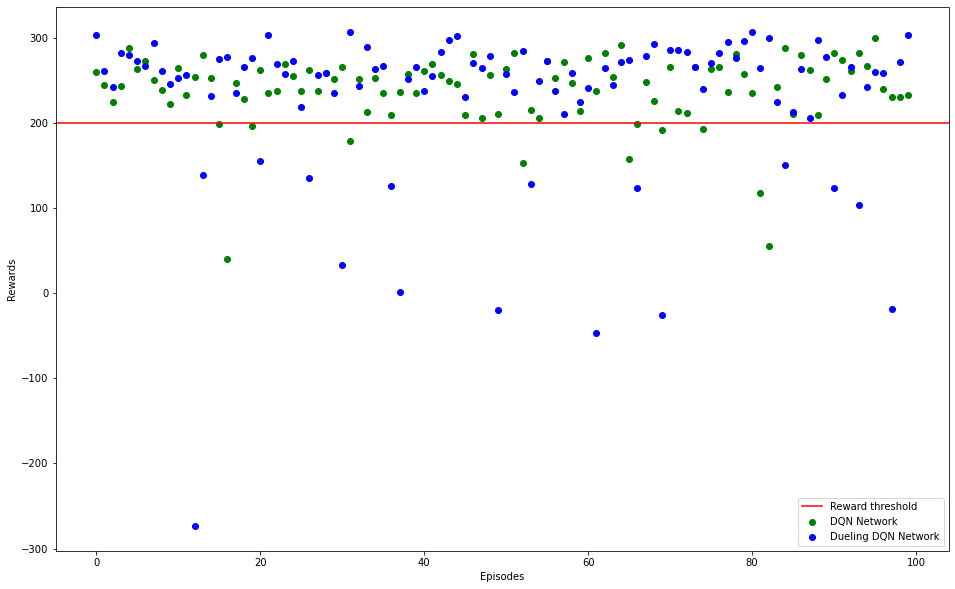

In [108]:
plt.scatter(range(len(total_reward_list_dqn)), total_reward_list_dqn, marker='o', c="green");
plt.scatter(range(len(total_reward_list_dueling)), total_reward_list_dueling, marker='o', c="blue");
plt.axhline(agent.reward_threshold, color='r', label="")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(['Reward threshold', 'DQN Network','Dueling DQN Network'], loc="lower right")
plt.show()

In [77]:
class Agent:
    """ Agent que interactua amb l'entorn i apren a través de DQN"""    
    def __init__(self, env, seed, learning_rate=1e-3, gamma=0.99, tau=1e-3, buffer_size=100000, batch_size=64, dnn_upd=4):
        """ Inicialitza l'agent per a l'aprenentatge per DQN
            L'agent inicialitza la xarxa neuronal local i target, el buffer de memòria i l'optimitzador    
        Params
        ======
            env: Entorn de gym
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            seed (int): Random seed per a inicialitzar els valors aleatoris
            learning_rate (float): Velocitat d'aprenentatge
            gamma (float): Valor gamma de l'equació de Bellman
            tau (float): Valor de tau per a soft update del target network
            buffer_size (int): Màxima capacitat del buffer
            batch_size (int): Conjunt a agafar del buffer per a la xarxa neuronal     
            dnn_upd (int): Freqüència d'actualització de la xarxa neuronal       
        """
        # Inicialització de paràmetres i printem tots els parametres d'entrada
        print(f'Agent: {datetime.now()}')
        print("seed: ", seed)
        print("learning_rate: ", learning_rate)
        print("gamma: ", gamma)
        print("tau: ", tau)
        print("buffer_size: ", buffer_size)
        print("batch_size: ", batch_size)
        print("dnn_upd: ", dnn_upd)

        self.env = env
        self.seed = seed         
        self.n_state = env.observation_space.shape[0] 
        self.n_action = env.action_space.n
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.buffer_size = buffer_size
        self.batch_size = batch_size        
        self.dnn_upd = dnn_upd
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu") # Si hi ha GPU, utilitza-la

         
        random.seed(seed)   

        if T.cuda.is_available():
            print(f'Running on {T.cuda.get_device_name(0)}')            
        else:
            print('Running on CPU')
               
        # Inicialització de les xarxes locals i target i de l'optimitzador
        self.__initialize_networks()

    def __initialize_networks(self):
        print("Inicialització de la xarxa neuronal DQN")

        # Inicialització de les xarxes locals i target            
        self.qnetwork_local = DQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        self.qnetwork_target = DQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        # Inicialització de l'optimitzador
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.learning_rate)

        # Inicialització del buffer de memòria
        self.memory = ReplayBuffer(self.n_action, self.buffer_size, self.batch_size, self.seed)
        
        # Inicialització del comptador de pasos per a l'actualització de la xarxa neuronal
        self.t_step = 0

    def __take_step(self, state, action, reward, next_state, done):
        """
        Afegeix l'experiència a la memòria i actualitza la xarxa neuronal
        """
        # emmagatzemar l'experiència en el buffer de memòria
        self.memory.append(state, action, reward, next_state, done)

        # Actualitzar la xarxa neuronal cada dnn_upd pasos
        self.t_step = (self.t_step + 1) % self.dnn_upd
        if self.t_step == 0:
            # Si hi ha suficients experiències en el buffer, agafar un lot i actualitzar la xarxa neuronal
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample_batch()
                self.__update(experiences, self.gamma)

    def get_action(self, state, eps):
        """
        Retorna l'acció segons l'estat actual i l'epsilon-greedy
        """
        # Convertir l'estat a un tensor de PyTorch
        state = T.from_numpy(state).float().unsqueeze(0).to(self.device)    
        # Passar a la fase d'avaluació per a desactivar el dropout    
        # Amb T.no_grad() no es calculen els gradients per a no fer backpropagation
        # Això ens permet agilitzar el càlcul de l'acció        
        self.qnetwork_local.eval()
        with T.no_grad():
            # Obtenir els valors Q de l'estat actual per a cada acció a partir de la xarxa neuronal local
            action_values = self.qnetwork_local(state)
        # tornar a la fase d'entrenament
        self.qnetwork_local.train()

        # Epsilon-greedy per a seleccionar l'acció. 
        # Si el valor aleatori és més gran que l'epsilon agafar l'acció amb el valor més alt segons la xarxa neuronal
        # Si no, agafar una acció aleatòria
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_action))

    def __update(self, experiences, gamma):
        """
        Actualitza els pesos de la xarxa neuronal local i target
        """
        states, actions, rewards, next_states, dones = experiences

        # obtenir els valors Q de l'estat següent segons la xarxa neuronal target
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # calcular els valors Q segons l'equació de Bellman teni en compte si l'estat és terminal i el parametre gamma
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        # obtenir els valors Q de l'estat actual segons la xarxa neuronal local
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # calcular la funció de pèrdua segons l'error quadràtic mitjà
        loss = F.mse_loss(q_expected, q_targets)

        # minimitzar la funció de pèrdua amb l'optimitzador
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

        # actualitzar els pesos de la xarxa neuronal target amb un soft update per a reduir el problema de l'estabilitat
        self.__soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def __normal_update(self, local_model, target_model):
        """
        Actualitza els pesos de la xarxa neuronal target
        """
        target_model.load_state_dict(local_model.state_dict())

    def __soft_update(self, local_model, target_model, tau):
        """
        Soft update dels pesos de la xarxa neuronal target
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)    


    def train(self, n_episodes=2000, max_t=1000, eps_start=1.0, eps_min=0.01, eps_decay=0.995, nblock =100, min_episodes=250, reward_threshold=200.0, solved_by_mean_reward=True):
        """Deep Q-Learning.

        Params
        ======
            n_episodes (int): nombre màxim d'episodis
            max_t (int): maxim nombre de pasos per episodi
            eps_start (float): valor inicial d'epsilon
            eps_min (float): valor mínim d'epsilon
            eps_decay (float): factor de decaig d'epsilon
        """
        self.solved_by_mean_reward = solved_by_mean_reward
        self.reward_threshold = reward_threshold
        self.eps = eps_start  # inicialitzar epsilon
        self.nblock = nblock
        self.total_episodes = 0
        
        self.update_loss = [] 
        self.mean_update_loss = [] # llista amb els valors de la funció de pèrdua per episodi
        
        self.sync_eps = [] 

        self.training_rewards = []  # llista amb els reward per episodi
        self.mean_training_rewards = []  # llista amb la mitjana dels reward per episodi

        start_time = datetime.now()
        print("Training...")
        
        for episode in range(1, n_episodes + 1):
            state = self.env.reset()
            self.total_reward = 0   
            self.total_time = 0
            
            for t in range(max_t):
                action = self.get_action(state, self.eps)
                next_state, reward, done, _ = self.env.step(action)
                self.__take_step(state, action, reward, next_state, done)
                state = next_state
                self.total_reward += reward
                if done:
                    break

            # actualitzar epsilon
            self.eps = max(eps_min, eps_decay * self.eps)  # decrease epsilon            
            
            # afegir el reward de l'episodi a la llista
            self.__save_statistics()
            
            # mostrar informació de l'episodi actual
            self.__log_info(start_time, episode)
            
            ### comprovar si s'ha assolit el màxim d'episodis
            if self.solved_by_mean_reward:
                training = not self.__is_solved_by_episode(episode, n_episodes) and not self.__is_solved_by_mean_reward(episode, min_episodes, self.__get_mean_training_rewards())
            else:
                training = not self.__is_solved_by_episode(episode, n_episodes) and not self.__is_solved_by_reward(episode, min_episodes, 97)                        
            ### si no s'ha assolit el màxim d'episodis, continuar entrenant
            if not training:
                print('\nTraining finished.')
                self.total_time = datetime.now() - start_time
                self.total_episodes = episode
                break

            if episode % 100 == 0:
                print('\rEpisode {}\tMean Rewards: {:.2f}\t'.format(episode, self.__get_mean_training_rewards()))
  

    ######## Recuperar la mitjana dels rewards de l'últim bloc d'episodis ########
    def __get_mean_training_rewards(self):
        return np.mean(self.training_rewards[-self.nblock:])

    ######## Emmagatzemar epsilon, training rewards i loss#######
    def __save_statistics(self):
        self.sync_eps.append(self.eps)              
        self.training_rewards.append(self.total_reward)         
        self.mean_training_rewards.append(np.mean(self.training_rewards[-self.nblock:]))
        self.mean_update_loss.append(np.mean(self.update_loss))                                         
        self.update_loss = []

    
    ######## Comprovar si s'ha arribat al llindar de recompensa i un mínim d'episodis
    def __is_solved_by_mean_reward(self, episode, min_episodios, mean_rewards):  
        if mean_rewards >= self.reward_threshold and min_episodios <  episode:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, mean_rewards))
            T.save(self.qnetwork_local.state_dict(), 'data.pth')
            return True
        else:
            return False

    ######## Cert si s'ha assolit un porcentatge de episodis amb un reward superior al threshold ########
    def __is_solved_by_reward(self, episode, min_episodes, percent):
        if (len(self.training_rewards) < self.nblock):
            return False
        sum_episodes = 0
        for i in range(self.nblock):
            if self.training_rewards[-i] > self.reward_threshold:
                sum_episodes += 1
        if episode % 100 == 0:
            print('\n\rSum episodes that are greater than the reward threshold:{}\t'.format(sum_episodes))                
        return (sum_episodes / self.nblock * 100) >= percent and episode >= min_episodes                


    ######## Comprovar si s'ha arribat al màxim d'episodis
    def __is_solved_by_episode(self, episode, max_episodes):
        if episode >= max_episodes:
            print('\nEpisode limit reached.')
            return True
        else:
            return False        


    ######## Mostrar informació de l'episodi actual
    def __log_info(self, start_time, episode):
        end_time = datetime.now()
        # get difference time
        delta = end_time - start_time 
        # time difference in minutes
        total_minutes = delta.total_seconds() / 60           
        print('\rEpisode {}\tMean Rewards: {:.2f}\tEpsilon {}\tTime {} minutes\t'
              .format(episode, self.__get_mean_training_rewards(), round(self.eps,4), round(total_minutes,2)), end="")                    





In [78]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3               # Valor de tau per a soft update del target network
LEARNING_RATE = 5e-4    # Velocitat d'aprenentatge
DNN_UPD = 3            # Freqüència d'actualització de la xarxa neuronal

N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 200  # Valor de recompensa per a considerar l'entrenament com a completat

# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')
# inicialització de l'agent amb els paràmetres de l'exercici
agent_dqn_best_solution = Agent(env, seed=0, learning_rate=LEARNING_RATE, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=DNN_UPD)
# entrenament de l'agent
agent_dqn_best_solution.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, EPS_DECAY, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD, False)

env.close()


Agent: 2023-01-14 14:31:44.438950
seed:  0
learning_rate:  0.0005
gamma:  0.99
tau:  0.001
buffer_size:  100000
batch_size:  64
dnn_upd:  3
Running on CPU
Inicialització de la xarxa neuronal DQN
Training...
Episode 100	Mean Rewards: -172.11	Epsilon 0.6058	Time 0.15 minutes	
Sum episodes that are greater than the reward threshold:0	
Episode 100	Mean Rewards: -172.11	
Episode 200	Mean Rewards: -105.15	Epsilon 0.367	Time 0.74 minutes		
Sum episodes that are greater than the reward threshold:0	
Episode 200	Mean Rewards: -105.15	
Episode 300	Mean Rewards: -20.19	Epsilon 0.2223	Time 3.36 minutes		
Sum episodes that are greater than the reward threshold:0	
Episode 300	Mean Rewards: -20.19	
Episode 400	Mean Rewards: 83.45	Epsilon 0.1347	Time 6.07 minutes		
Sum episodes that are greater than the reward threshold:14	
Episode 400	Mean Rewards: 83.45	
Episode 500	Mean Rewards: 168.12	Epsilon 0.0816	Time 7.69 minutes	
Sum episodes that are greater than the reward threshold:46	
Episode 500	Mean Rewa

In [83]:
# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')
# inicialització de l'agent amb els paràmetres de l'exercici
agent_dueling_best_solution = DuelingAgent(env, seed=0, learning_rate=LEARNING_RATE, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=DNN_UPD)
# entrenament de l'agent
scores = agent_dueling_best_solution.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, EPS_DECAY, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD,False)

Agent: 2023-01-14 15:02:20.937616
seed:  0
learning_rate:  0.0005
gamma:  0.99
tau:  0.001
buffer_size:  100000
batch_size:  64
dnn_upd:  3
Running on CPU
Inicialització de la xarxa neuronal DQN
Sobreescrivim la xarxa neuronal local i target per a que siguin de tipus Dueling
Training...
Episode 100	Mean Rewards: -173.45	Epsilon 0.6058	Time 0.23 minutes	
Sum episodes that are greater than the reward threshold:0	
Episode 100	Mean Rewards: -173.45	
Episode 200	Mean Rewards: -83.93	Epsilon 0.367	Time 0.92 minutes			
Sum episodes that are greater than the reward threshold:0	
Episode 200	Mean Rewards: -83.93	
Episode 300	Mean Rewards: -32.20	Epsilon 0.2223	Time 4.2 minutes		
Sum episodes that are greater than the reward threshold:0	
Episode 300	Mean Rewards: -32.20	
Episode 400	Mean Rewards: 18.35	Epsilon 0.1347	Time 7.83 minutes		
Sum episodes that are greater than the reward threshold:6	
Episode 400	Mean Rewards: 18.35	
Episode 500	Mean Rewards: 191.32	Epsilon 0.0816	Time 9.86 minutes	
Sum

In [111]:
total_reward_list_dqn = play_games(env, agent_dqn_best_solution, 100)

print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_reward_list_dqn), np.std(total_reward_list_dqn)))

Episode 99/100.Mean reward for agent 8: 252.92409270158788 +/- 47.54639734536111


In [112]:
total_reward_list_dueling = play_games(env, agent_dueling_best_solution, 100)

print("Mean reward for agent {}: {} +/- {}".format(idx + 1, np.mean(total_reward_list_dueling), np.std(total_reward_list_dueling)))

Episode 99/100.Mean reward for agent 8: 261.10012460944426 +/- 30.290659277473182


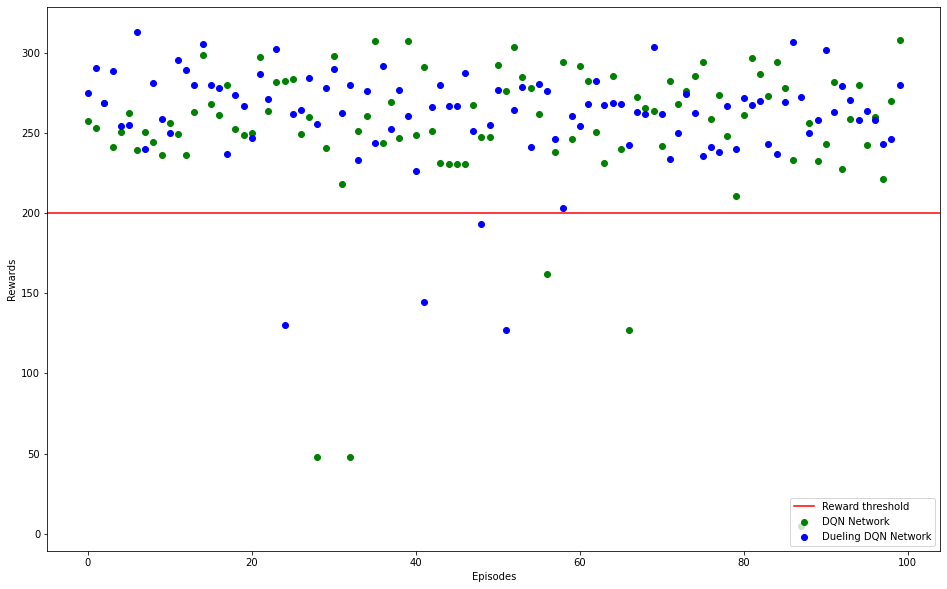

In [113]:
plt.scatter(range(len(total_reward_list_dqn)), total_reward_list_dqn, marker='o', c="green");
plt.scatter(range(len(total_reward_list_dueling)), total_reward_list_dueling, marker='o', c="blue");
plt.axhline(agent.reward_threshold, color='r')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(['Reward threshold', 'DQN Network','Dueling DQN Network'], loc="lower right")
plt.show()

Visualitzem dos vídeos un amb accions aleatories i amb l'agent entrenat.

In [49]:
from gym import wrappers

import glob
import base64
!pip install -q gym box2d-py pyvirtualdisplay
!pip install imageio-ffmpeg
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from base64 import b64encode


def play_games_recording(env, ag, num_games, video_name, random):       
    total_reward_list = []    
    video = VideoRecorder(env, video_name)
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        env.reset()
        state = env.reset()           
        total_reward = 0
        done = False
        while not done:
            env.render()
            video.capture_frame()
            if (random):
                action = env.action_space.sample()
            else:
                action = ag.get_action(state,eps=0.0)            
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    video.close()
    return video, total_reward_list

def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>' 

In [50]:
env = gym.make("LunarLander-v2")

before_video_path = "before_training.mp4"
video, total_reward_list = play_games_recording(env, dueling_agents[3], 10, before_video_path, True)
html = render_mp4(before_video_path)
HTML(html)

Episode 9/10.

In [51]:
env = gym.make("LunarLander-v2")

after_video_path = "after_training.mp4"
video, total_reward_list = play_games_recording(env, dueling_agents[5], 10, after_video_path, False)
                                                
html = render_mp4(after_video_path)
HTML(html)

Episode 9/10.